In [2]:
import pandas as pd

combined_df = pd.DataFrame()
# Load the CSV file
for sheet_name in ['Train', 'Test']:
    df = pd.read_excel('/orange/pinaki.sarder/f.afsari/5-Ingrowth_Brain/Data/source_train_test.xlsx', sheet_name=sheet_name)
    combined_df = pd.concat([combined_df, df], ignore_index=True)
combined_df.to_excel('/orange/pinaki.sarder/f.afsari/5-Ingrowth_Brain/Data/train_test.xlsx', index=False)



In [14]:
import torch
# Load the saved batch data
test_data = torch.load("train_val_loader_test.pt")

# Access the train and validation batches
train_batch = test_data['train_batch']
valid_batch = test_data['valid_batch']

# Test the train and validation batches (you can print, visualize, or check dimensions)
print("Train batch data:", train_batch[0].shape, train_batch[1].shape)
print("Validation batch data:", valid_batch[0].shape)
print('train batch type', train_batch[0].dtype)
print('valid batch type', valid_batch[0].dtype)


Train batch data: torch.Size([2, 3, 512, 512]) torch.Size([2, 1, 512, 512])
Validation batch data: torch.Size([2, 3, 512, 512])
train batch type torch.float32
valid batch type torch.float32


In [10]:
# from skimage.io import imread, imsave
import cv2

# img_name = '/orange/pinaki.sarder/f.afsari/5-Ingrowth_Brain/Data/images/56.TIF'
# tar_name = '/orange/pinaki.sarder/f.afsari/5-Ingrowth_Brain/Data/masks/56.TIF'
img_name = 'Y:\\f.afsari\\5-Ingrowth_Brain\\Data\\images\\56.TIF'
tar_name = 'Y:\\f.afsari\\5-Ingrowth_Brain\\Data\\masks\\56.TIF'


# img, tar = cv2.cvtColor(cv2.imread(str(img_name), cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB), cv2.imread(str(tar_name), cv2.IMREAD_GRAYSCALE)
try:
    img = cv2.imread(str(img_name), cv2.IMREAD_COLOR)
    tar = cv2.imread(str(tar_name), cv2.IMREAD_GRAYSCALE)
except ValueError:
    print('ValueError: Input image is not in RGB or grayscale format. Please convert it to RGB or grayscale format.')
    # img = cv2.imread(str(img_name), cv2.IMREAD_GRAYSCALE)
    # tar = cv2.imread(str(tar_name), cv2.IMREAD_GRAYSCALE)


print('image shape:', img.shape, 'mask shape:', tar.shape)


image shape: (2200, 2688, 3) mask shape: (2200, 2688)


In [4]:
import torch
import os
print(os.path.getsize("train_val_loader.pt"))
# Load the saved batch data
test_data = torch.load("train_val_loader_test.pt")

# Access the train and validation batches
train_batch = test_data['train_batch']
valid_batch = test_data['valid_batch']

# Test the train and validation batches (you can print, visualize, or check dimensions)
print("Train batch data:", train_batch)
print("Validation batch data:", valid_batch)



0


FileNotFoundError: [Errno 2] No such file or directory: 'train_val_loader_test.pt'

In [5]:
import torch
import segmentation_models_pytorch as smp
from torchvision.ops import SqueezeExcitation

class EnsembleModelSE(torch.nn.Module):
    def __init__(self,
                 encoder_name,
                 encoder_weights,
                 in_channels,
                 active,
                 n_classes,
                 dropout_rate=0.25):
        super().__init__()

        self.encoder_name = encoder_name
        self.encoder_weights = encoder_weights
        self.in_channels = in_channels
        self.active = active
        self.n_classes = n_classes
        self.dropout_rate = dropout_rate

        if self.active == 'sigmoid':
            self.final_active = torch.nn.Sigmoid()
        elif self.active == 'softmax':
            self.final_active = torch.nn.Softmax(dim=1)
        elif self.active == 'linear':
            self.active = None
            self.final_active = torch.nn.Identity()
        else:
            self.active = None
            self.final_active = torch.nn.ReLU()

        self.model_b = smp.UnetPlusPlus(
            encoder_name=self.encoder_name,
            encoder_weights=self.encoder_weights,
            in_channels=int(self.in_channels / 2),
            classes=self.n_classes,
            activation=self.active
        )

        self.model_d = smp.UnetPlusPlus(
            encoder_name=self.encoder_name,
            encoder_weights=self.encoder_weights,
            in_channels=int(self.in_channels / 2),
            classes=self.n_classes,
            activation=self.active
        )
        # Define SE blocks for each stage
        print("self.model_b.encoder.out_channels:", self.model_b.encoder.out_channels)
        self.se_blocks_b = torch.nn.ModuleList([
            SqueezeExcitation(ch, ch // 8) for ch in self.model_b.encoder.out_channels[1:]
        ])
        self.se_blocks_d = torch.nn.ModuleList([
            SqueezeExcitation(ch, ch // 8) for ch in self.model_d.encoder.out_channels[1:]
        ])

        self.segmentation_head = torch.nn.Sequential(
            torch.nn.LazyConv2d(64, kernel_size=1),#, padding=1),
            torch.nn.Dropout(p=self.dropout_rate),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(64, self.n_classes, kernel_size=1, bias=True)
        )

    def forward(self, input):
        b_input = input[:, 0:int(self.in_channels / 2), :, :]
        d_input = input[:, int(self.in_channels / 2):self.in_channels, :, :]

        # forward inputs to encoders
        b_output = self.model_b.encoder(b_input)
        d_output = self.model_d.encoder(d_input)

        print("b_output shapes:", [x.shape for x in b_output])
        print("d_output shapes:", [x.shape for x in d_output])

        # Apply SE blocks to encoder outputs
        b_output[1:] = [se_block(x) for se_block, x in zip(self.se_blocks_b, b_output[1:])]
        d_output[1:] = [se_block(x) for se_block, x in zip(self.se_blocks_d, d_output[1:])]

        print("b_output after SE shapes:", [x.shape for x in b_output])
        print("d_output after SE shapes:", [x.shape for x in d_output])

        # Concatenate the outputs from both models
        combined_output = [torch.cat((b_out, d_out), dim=1) for b_out, d_out in zip(b_output, d_output)]
        
        print("combined_output.shape:", len(combined_output), [combined_output[i].shape for i in range(6)])
        
        # Concatenate all combined outputs along the channel dimension
        # combined_output = torch.cat(combined_output, dim=1)

        print("combined_output.shape:", combined_output.shape)
        final_prediction = self.final_active(self.segmentation_head(combined_output))
        print("final_prediction.shape:", final_prediction.shape)

        return final_prediction
    
# Instantiate the model
model = EnsembleModelSE(
    encoder_name='resnet34',        # Example encoder name
    encoder_weights='imagenet',     # Example encoder weights
    in_channels=2,
    active='sigmoid',
    n_classes=1
)

# Create a sample input tensor with the shape (4, 6, 512, 512)
input_tensor = torch.randn(2, 2, 512, 512)

# Get the output from the model
output = model(input_tensor)

# Print the shape of the output
print(f"Output shape: {output.shape}")


self.model_b.encoder.out_channels: (1, 64, 64, 128, 256, 512)
b_output shapes: [torch.Size([2, 1, 512, 512]), torch.Size([2, 64, 256, 256]), torch.Size([2, 64, 128, 128]), torch.Size([2, 128, 64, 64]), torch.Size([2, 256, 32, 32]), torch.Size([2, 512, 16, 16])]
d_output shapes: [torch.Size([2, 1, 512, 512]), torch.Size([2, 64, 256, 256]), torch.Size([2, 64, 128, 128]), torch.Size([2, 128, 64, 64]), torch.Size([2, 256, 32, 32]), torch.Size([2, 512, 16, 16])]
b_output after SE shapes: [torch.Size([2, 1, 512, 512]), torch.Size([2, 64, 256, 256]), torch.Size([2, 64, 128, 128]), torch.Size([2, 128, 64, 64]), torch.Size([2, 256, 32, 32]), torch.Size([2, 512, 16, 16])]
d_output after SE shapes: [torch.Size([2, 1, 512, 512]), torch.Size([2, 64, 256, 256]), torch.Size([2, 64, 128, 128]), torch.Size([2, 128, 64, 64]), torch.Size([2, 256, 32, 32]), torch.Size([2, 512, 16, 16])]
combined_output.shape: 6 [torch.Size([2, 2, 512, 512]), torch.Size([2, 128, 256, 256]), torch.Size([2, 128, 128, 128]), 

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 512 but got size 256 for tensor number 1 in the list.

In [3]:

x = torch.randn(16, 512, 512)
y = torch.randn(16, 512, 512)
x=x.unsqueeze(0)
y=y.unsqueeze(0)
print(x.shape)
z=torch.cat((x, y), dim=0)
print(z.shape)


torch.Size([1, 16, 512, 512])
torch.Size([2, 16, 512, 512])


In [31]:
import torch

if torch.cuda.is_available():
    torch.cuda.empty_cache()

x_s = torch.rand((4, 1, 512, 512))
x_t = torch.rand((4, 1, 512, 512))
# Assuming x_s is your input tensor and sigma is your kernel parameter
print("x_s.shape:", x_s.shape)

def compute_kernel_with_batching(x_s, sigma, batch_size=1000):
    n = x_s.size(0)
    x_s_kernel = []
    for i in range(0, n, batch_size):
        batch_x_s = x_s[i:i+batch_size]
        print(batch_x_s.shape)
        distances = torch.pow(batch_x_s.unsqueeze(1) - x_s.unsqueeze(0), 2).sum(2)

        # Calculate kernel for this batch
        kernel_batch = torch.exp(-distances / (2 * sigma**2)).mean(dim=1)
        x_s_kernel.append(kernel_batch)
    
    x_s_kernel = torch.cat(x_s_kernel)
    
    return x_s_kernel

# Example usage
sigma = 2.0  # Example value for sigma, adjust as needed
x_s_kernel = compute_kernel_with_batching(x_s, sigma, batch_size=1000)
x_t_kernel = compute_kernel_with_batching(x_t, sigma, batch_size=1000)
mmd = torch.pow(x_s_kernel.mean() - x_t_kernel.mean(), 2)

print("x_s_kernel.shape:", x_s_kernel.shape)
print(mmd)


x_s.shape: torch.Size([4, 1, 512, 512])
torch.Size([4, 1, 512, 512])
torch.Size([4, 1, 512, 512])
x_s_kernel.shape: torch.Size([4, 512, 512])
tensor(1.7013e-09)


In [35]:
# Example usage
sigma = 1.0 # Example value for sigma, adjust as needed
x_s_kernel = compute_kernel_with_batching(x_s, sigma, batch_size=1000)
x_t_kernel = compute_kernel_with_batching(x_t, sigma, batch_size=1000)
mmd = torch.pow(x_s_kernel.mean() - x_t_kernel.mean(), 2)

print("x_s_kernel.shape:", x_s_kernel.shape)
print(mmd)


torch.Size([4, 1, 512, 512])
torch.Size([4, 1, 512, 512])
x_s_kernel.shape: torch.Size([4, 512, 512])
tensor(1.7013e-09)


In [38]:
from skimage.filters import threshold_otsu

pred_s = torch.rand((4, 1, 512, 512))
pred_t = torch.rand((4, 1, 512, 512))

threshold_s = threshold_otsu(pred_s.detach().cpu().numpy())
threshold_t = threshold_otsu(pred_t.detach().cpu().numpy())

# Thresholding predictions
labels_s = torch.where(pred_s >= threshold_s, torch.tensor(1), torch.tensor(0))
labels_t = torch.where(pred_t >= threshold_t, torch.tensor(1), torch.tensor(0))

# print("label_s.shape:", labels_s.shape)

num_classes = 2  # Assuming binary classification after thresholding
mmd_losses = []

for class_idx in range(num_classes):

    # Create masks for class_idx
    mask_s = (labels_s == class_idx).float()
    mask_t = (labels_t == class_idx).float()
    # Apply masks to retain the same shape as pred_s and pred_t
    x_s_c = pred_s * mask_s
    x_t_c = pred_t * mask_t

    # MMD loss calculation
    mmd_loss_c = torch.abs(x_s_c.mean() - x_t_c.mean())
    print("x_s_c.shape:", x_s_c.shape)      
    # Compute MMD
    # mmd_loss_c = mmd_loss(x_s_c, x_t_c)
    mmd_losses.append(mmd_loss_c)

# Aggregate all losses
mean_mmd_loss = torch.stack(mmd_losses).mean()
print(mean_mmd_loss)

# Example usage
sigma = 1.0 # Example value for sigma, adjust as needed
x_s_kernel = compute_kernel_with_batching(pred_s, sigma, batch_size=1000)
x_t_kernel = compute_kernel_with_batching(pred_t, sigma, batch_size=1000)
mmd = torch.pow(x_s_kernel.mean() - x_t_kernel.mean(), 2)

print("x_s_kernel.shape:", x_s_kernel.shape)
print(mmd)


x_s_c.shape: torch.Size([4, 1, 512, 512])
x_s_c.shape: torch.Size([4, 1, 512, 512])
tensor(0.0004)
torch.Size([4, 1, 512, 512])
torch.Size([4, 1, 512, 512])
x_s_kernel.shape: torch.Size([4, 512, 512])
tensor(2.5247e-09)


In [40]:
torch.nn.functional.mse_loss(pred_s, pred_t)


tensor(0.1664)

In [12]:
import pandas as pd
import shutil
import os

# Define paths from Excel file and desired target paths
excel_file = '/blue/pinaki.sarder/f.afsari/3-Beit/DN_Labels_Fatemeh_SKorea_preds.xlsx'
target_base_path = '/blue/pinaki.sarder/f.afsari/3-Beit/SKorea_Data'
stats_file = '/blue/pinaki.sarder/f.afsari/3-Beit/stats.xlsx'

# Load Excel file
df = pd.read_excel(excel_file)

# Initialize a dictionary to store statistics
stats = {}

# Function to create necessary folders
def create_folders(base_path, case_id):
    folders = ['Glom_I_IIa', 'Glom_IIb', 'Glom_III_IV', 'SclGlom_I_IIa', 'SclGlom_IIb', 'SclGlom_III_IV']
    case_path = os.path.join(base_path, case_id)
    os.makedirs(case_path, exist_ok=True)
    for folder in folders:
        os.makedirs(os.path.join(case_path, folder), exist_ok=True)

# Iterate through each row in the dataframe
for index, row in df.iterrows():
    image_path = row['image path']
    dn_label = row['DN label']
    
    # Extract classID from image_path
    target_subfolder = image_path.split('/')[6]
    
    # Extract caseID from image_path
    case_id = image_path.split('/')[7]
           
    # Create necessary folders if they don't exist
    target_path = os.path.join(target_base_path, target_subfolder)
    create_folders(target_path, case_id)
    
    # Determine specific subfolder (Glom or SclGlom)
    if 'Glomeruli' in image_path:
        subfolders = ['Glom_I_IIa', 'Glom_IIb', 'Glom_III_IV']
    elif 'Sclerotic_glomeruli' in image_path:
        subfolders = ['SclGlom_I_IIa', 'SclGlom_IIb', 'SclGlom_III_IV']
    else:
        continue  # Skip if neither Glomeruli nor Sclerotic_glomeruli found in image_path
    
    # Determine destination folder based on dn_label
    if dn_label == 0:
        dest_folder = subfolders[0]
    elif dn_label == 1:
        dest_folder = subfolders[1]
    elif dn_label == 2:
        dest_folder = subfolders[2]
    else:
        continue  # Skip if dn_label is unexpected
    
    # Construct destination folder path
    dest_path = os.path.join(target_path, case_id, dest_folder)
    
    # Copy image to destination folder
    # shutil.copy(image_path, dest_path)
    
    # Update statistics dictionary
    if case_id not in stats:
        stats[case_id] = {'Glom_I_IIa': 0, 'Glom_IIb': 0, 'Glom_III_IV': 0,
                          'SclGlom_I_IIa': 0, 'SclGlom_IIb': 0, 'SclGlom_III_IV': 0}
    
    stats[case_id][dest_folder] += 1

print("Copying complete.")

# Convert statistics to DataFrame
stats_df = pd.DataFrame(stats).T  # Transpose to have case_id as index

# Reorder columns to match desired order
columns_order = ['Glom_I_IIa', 'Glom_IIb', 'Glom_III_IV',
                 'SclGlom_I_IIa', 'SclGlom_IIb', 'SclGlom_III_IV']
stats_df = stats_df[columns_order]

# Save statistics to stats.xlsx
stats_df.to_excel(stats_file)

print(f"Statistics saved to {stats_file}.")


Copying complete.
Statistics saved to /blue/pinaki.sarder/f.afsari/3-Beit/stats.xlsx.


In [2]:
import torch
import torch.nn.init as init
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.base.modules import Activation
from CollagenModels import EnsembleModel

source_model = EnsembleModel(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=6,
    active="sigmoid",
    n_classes=1
)
target_model = EnsembleModel(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=6,
    active="sigmoid",
    n_classes=1
)
# print(source_model)

model_path = "/blue/pinaki.sarder/f.afsari/4-DUET/DUET UCD PATH vs CGPL/UCD-PATH/Results/Ensemble_DA_V51_RGB/models/Collagen_Seg_Model_Latest.pth"

print(f"Loading pre-trained model from {model_path}")            
source_model.load_state_dict(torch.load(model_path, map_location=device), strict=False)        

# Update target model's state_dict with source model's parameters
source_state_dict = source_model.state_dict()
target_state_dict = target_model.state_dict()
target_state_dict.update(source_state_dict)

# Load the updated state_dict into target model
target_model.load_state_dict(target_state_dict, strict=False)
with torch.no_grad():
    teacher_preds_unsup = target_model(target_adapt_inputs)  

    # print("Before:", target_adapt_inputs.shape, teacher_preds_unsup.shape)            
    adapt_input_batch, teacher_preds_unsup_aug = linked_batch_augmentation(target_adapt_inputs, teacher_preds_unsup)
    adapt_input_batch, teacher_preds_unsup_aug = adapt_input_batch.to(device), teacher_preds_unsup_aug.to(device)
    # print("After:", adapt_input_batch.shape, teacher_preds_unsup_aug.shape)

    # Student forward
    student_preds_unsup = source_model(adapt_input_batch)



EnsembleModelMAnet(
  (final_active): Sigmoid()
  (model_b): MAnet(
    (encoder): MixVisionTransformerEncoder(
      (patch_embed1): OverlapPatchEmbed(
        (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
        (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
      (patch_embed2): OverlapPatchEmbed(
        (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      )
      (patch_embed3): OverlapPatchEmbed(
        (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
      )
      (patch_embed4): OverlapPatchEmbed(
        (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      )
      (block1): ModuleList(
        (0): Block(
          (norm1): LayerNorm((64,

In [8]:
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp

# Dice Loss Function
def dice_loss(pred, target):
    smooth = 1.0  # Add a smoothing factor to avoid division by zero    
    intersection = (pred * target).sum()
    dice = (2.0 * intersection + smooth) / (pred.sum() + target.sum() + smooth)
    return 1.0 - dice

# Instantiate the MSELoss object
mse_loss1 = nn.MSELoss(reduction='mean')

# Example predictions and targets
predictions = torch.rand((2, 1, 3, 3))
targets     = torch.rand((2, 1, 3, 3))
print(predictions, targets, sep='\n')

# Compute the loss
loss1 = mse_loss1(predictions, targets)
loss2 = nn.functional.mse_loss(predictions, targets)
if loss1.item() == loss2.item():
    print(loss1, loss2)


tensor([[[[0.0285, 0.7112, 0.0295],
          [0.8838, 0.0683, 0.0065],
          [0.5873, 0.7001, 0.0406]]],


        [[[0.4423, 0.2858, 0.4035],
          [0.7149, 0.7786, 0.3404],
          [0.4679, 0.6243, 0.8565]]]])
tensor([[[[0.3944, 0.2367, 0.7046],
          [0.1021, 0.9779, 0.3262],
          [0.3089, 0.1201, 0.5000]]],


        [[[0.8144, 0.2760, 0.2677],
          [0.0299, 0.8618, 0.4654],
          [0.2584, 0.4057, 0.6231]]]])
tensor(0.2097) tensor(0.2097)


In [12]:
dice_loss_smp = smp.losses.DiceLoss(mode='binary', from_logits=True)
print(dice_loss(predictions, targets), dice_loss_smp(predictions, targets))


tensor(0.5853) tensor(0.5107)


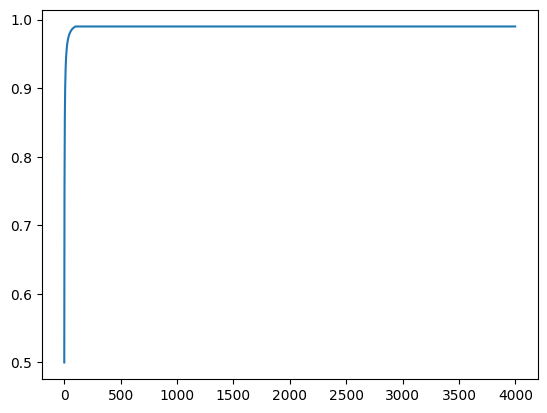

In [25]:
import numpy as np
import matplotlib.pyplot as plt

alpha = 0.99
alpha_list = []

for global_step in range(1,4000):
    new_alpha = min(1 - 1 / (global_step + 1), alpha)
    if new_alpha == alpha:
        print(global_step)
        # print(alpha_list)
        # break
    alpha_list.append(new_alpha)

plt.plot(alpha_list)

plt.show()


In [17]:
import torch

# Create some sample tensors with higher precision
target_param = torch.tensor([1.0, 2.0, 3.0], dtype=torch.float64)
source_param = torch.tensor([4.0, 5.0, 6.0], dtype=torch.float64)
alpha = 0.7  # Learning rate like parameter

# In-place update with combined operation
# target_param.data.mul_(alpha).add_(1 - alpha, source_param.data)
one_minus_alpha = 1-alpha
target_param.data.mul_(alpha).add_(source_param.data.mul_(one_minus_alpha))

# Print the updated target_param
print("Updated target_param (in-place):", target_param)

# Explicit update for comparison
updated_target_param = target_param.data * alpha + one_minus_alpha * source_param.data

# Print the explicitly updated target_param
print("Updated target_param (explicit):", updated_target_param)


Updated target_param (in-place): tensor([1.9000, 2.9000, 3.9000], dtype=torch.float64)
Updated target_param (explicit): tensor([1.6900, 2.4800, 3.2700], dtype=torch.float64)


In [20]:
target_param = torch.tensor([1.0, 2.0, 3.0], dtype=torch.float32)
source_param = torch.tensor([4.0, 5.0, 6.0], dtype=torch.float32)

target_param.data.mul_(alpha).add_(one_minus_alpha, source_param.data)

# Print the updated target_param
print("Updated target_param (in-place):", target_param)


Updated target_param (in-place): tensor([1.9000, 2.9000, 3.9000])


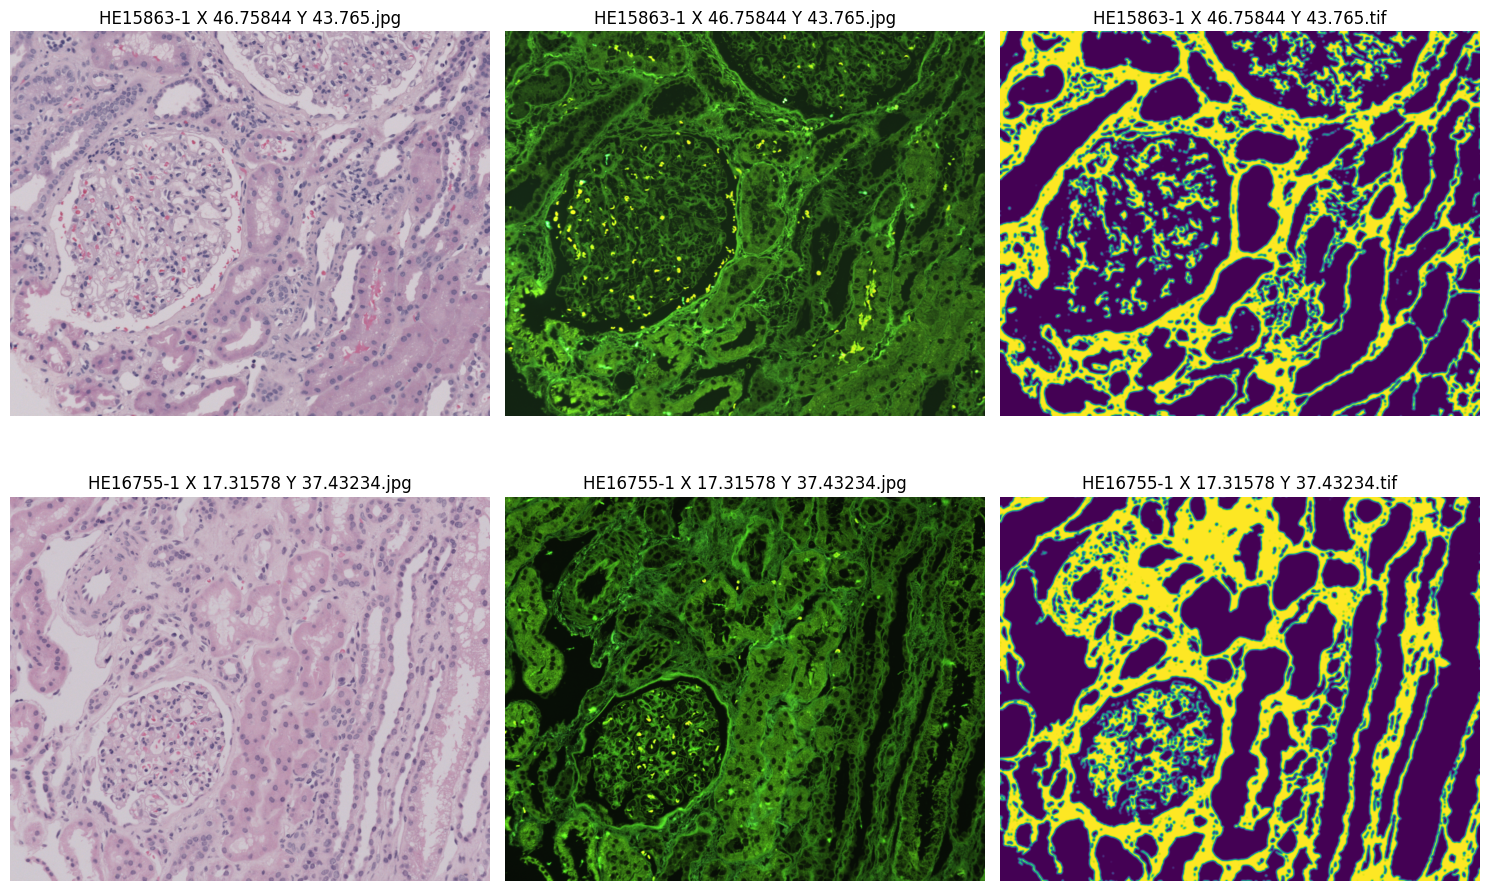

In [9]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
from math import floor

def patch_image(image_files, image_size=(512, 512)):
    
    # Open all images
    imgs = [Image.open(image_files[i]) for i in range(len(image_files))]
    
    img = imgs[0]
    # Patch size and overlap
    patch_size = (int(image_size[0]) , int(image_size[1])) 
    # Overlap percentage, hardcoded patch size
    # patch_size = [image_size[0], image_size[1]]
    patch_batch = 0.25
    # Correction for downsampled (10X as opposed to 20X) data
    downsample_level = 0.5
    stride = [int(patch_size[0]*(1-patch_batch)*downsample_level), int(patch_size[1]*(1-patch_batch)*downsample_level)]

    # Calculating and storing patch coordinates for each image and reading those regions at training time :/
    n_patches = [1+floor((np.shape(img)[0]-patch_size[0])/stride[0]), 1+floor((np.shape(img)[1]-patch_size[1])/stride[1])]
    start_coords = [0,0]

    row_starts = [int(start_coords[0]+(i*stride[0])) for i in range(0,n_patches[0])]
    col_starts = [int(start_coords[1]+(i*stride[1])) for i in range(0,n_patches[1])]
    row_starts.append(int(np.shape(img)[0]-patch_size[0]))
    col_starts.append(int(np.shape(img)[1]-patch_size[1]))

    # Create patches and save
    for img, image_name in zip(imgs, image_files):
        # img_basename = os.path.basename(image_name)
        
        for r_s in row_starts:
            for c_s in col_starts:
                # Define the region for cropping
                box = (c_s, r_s, c_s + patch_size[0], r_s + patch_size[1])
                
                # Crop and create a new patch
                patch = img.crop(box)
                
                # Create a new file name for the patch
                base_name = os.path.splitext(image_name)[0]
                extension = os.path.splitext(image_name)[1]
                patch_name = f"{base_name}_{r_s}_{c_s}{extension}"
                
                # Save the patch
                patch.save(patch_name)

# Base path to the folder containing subfolders
base_path = "/blue/pinaki.sarder/f.afsari/4-DUET/DUET UCD PATH vs CGPL/UCD-PATH"

# Names of the subfolders
subfolders = ["B", "F", "M"]


# List of image file paths from all subfolders
B_image_files = [os.path.join(base_path, "B", f) for f in os.listdir(os.path.join(base_path, "B")) if f.endswith(('.png', '.jpg', '.jpeg', '.tiff', '.tif'))]

# Determine the number of rows and columns for subplots
num_images = len(B_image_files)  
num_cols = 3
num_rows = num_images

# Create a figure with the required number of subplots
plt.figure(figsize=(15, 5 * num_rows))
i = 1

for b_image in B_image_files: #zip(all_image_files[0], all_image_files[1], all_image_files[2]):
    
    image_basename = os.path.basename(b_image)
    f_image = os.path.join(base_path, "F", image_basename)
    m_image = os.path.join(base_path, "M", image_basename).replace('.jpg', '.tif')
    
    c_image = [b_image, f_image, m_image]
    
    patch_image(c_image)
    
    # Loop through each subplot (1, 2, 3)
    for image_path, folder_name in zip(c_image, subfolders):
        
        # Open the image
        img = Image.open(image_path)
        
        # Display the image in the corresponding subplot
        plt.subplot(num_rows, num_cols, i)  # Define the grid and subplot index
        plt.imshow(np.array(img))
        # plt.title(folder_name)  # Use the image file name as the title
        plt.title(os.path.basename(image_path))  # Use the image file name as the title
        plt.axis("off")  # Hide axis ticks and labels
        i += 1

# Display all images in the figure
plt.tight_layout()  # Ensure proper spacing between subplots
plt.show()


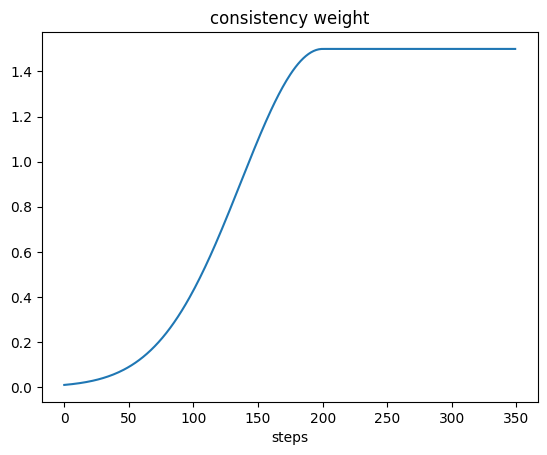

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def get_current_consistency_weight(weight, epoch, rampup):
    """Consistency ramp-up from https://arxiv.org/abs/1610.02242"""
    # print(f"Sigmoid ramp-up value at step {epoch} with ramp-up length {rampup}: {sigmoid_rampup(epoch, rampup)}, ")
    return weight * sigmoid_rampup(epoch, rampup)


def sigmoid_rampup(current, rampup_length):
    if rampup_length == 0:
        return 1.0
    else:
        current = np.clip(current, 0.0, rampup_length)
        phase = 1.0 - current / rampup_length
        return float(np.exp(-5.0 * phase * phase))

# Example usage
current_step = 1
rampup_length = 200
result = sigmoid_rampup(current_step, rampup_length)
# print(f"Sigmoid ramp-up value at step {current_step} with ramp-up length {rampup_length}: {result}")
w = []
for epoch in range(350):
    # print(f"Weight: {get_current_consistency_weight(1.5, epoch, rampup_length)}")
    w.append(get_current_consistency_weight(1.5, epoch, rampup_length))

plt.plot(w)
plt.title("consistency weight")
plt.xlabel("steps")
plt.show()


In [26]:
import numpy as np

train_images = [["a", "abbbc"], ["a", "mmma"], ["a", "ass"]]
train_labels = [["b", "b"], ["b", "b"], ["b", "b"]]
test_images = [["c", "c"], ["c", "c"]]
test_labels = [["d", "d"], ["d", "d"]]

# save train_val idx
np.save("source_images_train.npy", [train_images, train_labels])
np.save("source_images_test.npy", [test_images, test_labels])


target_images_list = np.load("source_images_train.npy", allow_pickle=True)
target_images_list2 = np.load("source_images_test.npy", allow_pickle=True)
               
print(target_images_list.shape)
print(target_images_list2.shape)



(2, 3, 2)
(2, 2, 2)


In [23]:
train_images, train_labels = target_images_list[0], target_images_list[1]
test_images, test_labels = target_images_list2[0], target_images_list2[1]
print(train_images, train_labels, test_images, test_labels)


[['a' 'a']
 ['a' 'a']
 ['a' 'a']] [['b' 'b']
 ['b' 'b']
 ['b' 'b']] [['c' 'c']
 ['c' 'c']] [['d' 'd']
 ['d' 'd']]


In [7]:
import torch
import segmentation_models_pytorch as smp

class EnsembleModelMIT(torch.nn.Module):
    def __init__(self,
                 in_channels,
                 active,
                 n_classes):
        super().__init__()

        self.in_channels = in_channels
        self.active = active
        self.n_classes = n_classes

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        encoder = 'mit_b5'
        encoder_weights = 'imagenet'

        if self.active=='sigmoid':
            self.final_active = torch.nn.Sigmoid()
        elif self.active =='softmax':
            self.final_active = torch.nn.Softmax(dim=1)       
        elif self.active == 'linear':
            self.active = None
            self.final_active = torch.nn.Identity()
        else:
            self.active = None
            self.final_active = torch.nn.ReLU()

        self.model_b = smp.Unet(
                encoder_name = encoder,
                encoder_weights = encoder_weights,
                in_channels = int(self.in_channels/2),
                classes = self.n_classes,
                activation = self.active
                )
        
        self.model_d = smp.Unet(
            encoder_name = encoder,
            encoder_weights = encoder_weights,
            in_channels = int(self.in_channels/2),
            classes = self.n_classes,
            activation = self.active
        )

        self.combine_layers = torch.nn.Sequential(
            torch.nn.LazyConv2d(64,kernel_size=1),
            torch.nn.Dropout(p=0.1),
            # torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(64,self.n_classes,kernel_size=1)
        )

    def forward(self,input):

        b_input = input[:,0:int(self.in_channels/2),:,:]
        d_input = input[:,int(self.in_channels/2):self.in_channels,:,:]
        b_output = self.model_b.decoder(*self.model_b.encoder(b_input))
        d_output = self.model_d.decoder(*self.model_d.encoder(d_input))

        self.features = torch.cat((b_output,d_output),dim=1)
        final_prediction = self.final_active(self.combine_layers(self.features))
        
        return final_prediction

model_details = {
            "architecture":"ensembleMIT",
            "encoder":"mit_b5",
            "encoder_weights":"imagenet",
            "active":"sigmoid",
            "target_type":"nonbinary",
            "in_channels":6,
            "ann_classes":"background,collagen"
        }

source_model = EnsembleModelMIT(
            in_channels = model_details['in_channels'],
            active = model_details['active'],
            n_classes = 1
            )
target_model = EnsembleModelMIT(
            in_channels = model_details['in_channels'],
            active = model_details['active'],
            n_classes = 1
            )

model_path = "/blue/pinaki.sarder/f.afsari/4-DUET/Data/Results/Ensemble_MIT5_RGB/models/Collagen_Seg_Model_Latest.pth"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device:", device)

# pretrained_dict = torch.load(model_path, map_location=device)

# Print the keys of the pre-trained state dictionary
print("Pre-trained model state dict keys:")
print("Number of Pretrained keys:", len(pretrained_dict.keys()))



device: cuda
Pre-trained model state dict keys:
Number of Pretrained keys: 2232


In [8]:

source_model.to(device)
target_model.to(device)

# Load the state dictionary with non-strict mode
source_model.load_state_dict(pretrained_dict, strict=False)

# Update target model's state_dict with source model's parameters
source_state_dict = source_model.state_dict()
target_state_dict = target_model.state_dict()
target_state_dict.update(source_state_dict)

# Load the updated state_dict into target model
target_model.load_state_dict(target_state_dict)

for param in target_model.parameters():
    param.detach_()


In [9]:
print("Number of source keys", len(source_state_dict.keys()))
print("Number of target keys", len(target_state_dict.keys()))
# Function to print unmatched keys
def print_unmatched_keys(model_dict, loaded_dict):
    missing_keys = [k for k in model_dict.keys() if k not in loaded_dict]
    unexpected_keys = [k for k in loaded_dict.keys() if k not in model_dict]
    
    print("Missing keys in loaded state_dict:")
    for key in missing_keys:
        print(key)
    
    print("\nUnexpected keys in loaded state_dict:")
    for key in unexpected_keys:
        print(key)

# Call the function to print unmatched keys
print_unmatched_keys(pretrained_dict, source_state_dict)


Number of source keys 2232
Number of target keys 2232
Missing keys in loaded state_dict:

Unexpected keys in loaded state_dict:


In [15]:
import torch

# Load the pre-trained state dictionary
pretrained_dict = torch.load(model_path)

# Print the keys of the pre-trained state dictionary
print("Pre-trained model state dict keys:")
key_cnt = 0
for key in pretrained_dict.keys():
    print(key)
    key_cnt += 1
print("Number of all keys:", key_cnt)


Pre-trained model state dict keys:
model_b.encoder.conv1.weight
model_b.encoder.bn1.weight
model_b.encoder.bn1.bias
model_b.encoder.bn1.running_mean
model_b.encoder.bn1.running_var
model_b.encoder.bn1.num_batches_tracked
model_b.encoder.layer1.0.conv1.weight
model_b.encoder.layer1.0.bn1.weight
model_b.encoder.layer1.0.bn1.bias
model_b.encoder.layer1.0.bn1.running_mean
model_b.encoder.layer1.0.bn1.running_var
model_b.encoder.layer1.0.bn1.num_batches_tracked
model_b.encoder.layer1.0.conv2.weight
model_b.encoder.layer1.0.bn2.weight
model_b.encoder.layer1.0.bn2.bias
model_b.encoder.layer1.0.bn2.running_mean
model_b.encoder.layer1.0.bn2.running_var
model_b.encoder.layer1.0.bn2.num_batches_tracked
model_b.encoder.layer1.1.conv1.weight
model_b.encoder.layer1.1.bn1.weight
model_b.encoder.layer1.1.bn1.bias
model_b.encoder.layer1.1.bn1.running_mean
model_b.encoder.layer1.1.bn1.running_var
model_b.encoder.layer1.1.bn1.num_batches_tracked
model_b.encoder.layer1.1.conv2.weight
model_b.encoder.layer

In [17]:
# Load pre-trained model
pretrained_path = model_path
pretrained_dict = torch.load(pretrained_path)

# Instantiate an empty model object
model = torch.nn.Module()
# model = EnsembleModelMIT(
#             in_channels = model_details['in_channels'],
#             active = model_details['active'],
#             n_classes = 1
#             )


# Load state_dict into the model (this assumes the keys match the model's structure)
model.load_state_dict(pretrained_dict)

# Print the keys of your model's state dictionary
print("\nMy model state dict keys:")
key_cnt1 = 0
for key in model.keys():
    # print(key)
    key_cnt1 += 1
print("Number of keys:", key_cnt1, key_cnt-key_cnt1)


RuntimeError: Error(s) in loading state_dict for Module:
	Unexpected key(s) in state_dict: "model_b.encoder.conv1.weight", "model_b.encoder.bn1.weight", "model_b.encoder.bn1.bias", "model_b.encoder.bn1.running_mean", "model_b.encoder.bn1.running_var", "model_b.encoder.bn1.num_batches_tracked", "model_b.encoder.layer1.0.conv1.weight", "model_b.encoder.layer1.0.bn1.weight", "model_b.encoder.layer1.0.bn1.bias", "model_b.encoder.layer1.0.bn1.running_mean", "model_b.encoder.layer1.0.bn1.running_var", "model_b.encoder.layer1.0.bn1.num_batches_tracked", "model_b.encoder.layer1.0.conv2.weight", "model_b.encoder.layer1.0.bn2.weight", "model_b.encoder.layer1.0.bn2.bias", "model_b.encoder.layer1.0.bn2.running_mean", "model_b.encoder.layer1.0.bn2.running_var", "model_b.encoder.layer1.0.bn2.num_batches_tracked", "model_b.encoder.layer1.1.conv1.weight", "model_b.encoder.layer1.1.bn1.weight", "model_b.encoder.layer1.1.bn1.bias", "model_b.encoder.layer1.1.bn1.running_mean", "model_b.encoder.layer1.1.bn1.running_var", "model_b.encoder.layer1.1.bn1.num_batches_tracked", "model_b.encoder.layer1.1.conv2.weight", "model_b.encoder.layer1.1.bn2.weight", "model_b.encoder.layer1.1.bn2.bias", "model_b.encoder.layer1.1.bn2.running_mean", "model_b.encoder.layer1.1.bn2.running_var", "model_b.encoder.layer1.1.bn2.num_batches_tracked", "model_b.encoder.layer1.2.conv1.weight", "model_b.encoder.layer1.2.bn1.weight", "model_b.encoder.layer1.2.bn1.bias", "model_b.encoder.layer1.2.bn1.running_mean", "model_b.encoder.layer1.2.bn1.running_var", "model_b.encoder.layer1.2.bn1.num_batches_tracked", "model_b.encoder.layer1.2.conv2.weight", "model_b.encoder.layer1.2.bn2.weight", "model_b.encoder.layer1.2.bn2.bias", "model_b.encoder.layer1.2.bn2.running_mean", "model_b.encoder.layer1.2.bn2.running_var", "model_b.encoder.layer1.2.bn2.num_batches_tracked", "model_b.encoder.layer2.0.conv1.weight", "model_b.encoder.layer2.0.bn1.weight", "model_b.encoder.layer2.0.bn1.bias", "model_b.encoder.layer2.0.bn1.running_mean", "model_b.encoder.layer2.0.bn1.running_var", "model_b.encoder.layer2.0.bn1.num_batches_tracked", "model_b.encoder.layer2.0.conv2.weight", "model_b.encoder.layer2.0.bn2.weight", "model_b.encoder.layer2.0.bn2.bias", "model_b.encoder.layer2.0.bn2.running_mean", "model_b.encoder.layer2.0.bn2.running_var", "model_b.encoder.layer2.0.bn2.num_batches_tracked", "model_b.encoder.layer2.0.downsample.0.weight", "model_b.encoder.layer2.0.downsample.1.weight", "model_b.encoder.layer2.0.downsample.1.bias", "model_b.encoder.layer2.0.downsample.1.running_mean", "model_b.encoder.layer2.0.downsample.1.running_var", "model_b.encoder.layer2.0.downsample.1.num_batches_tracked", "model_b.encoder.layer2.1.conv1.weight", "model_b.encoder.layer2.1.bn1.weight", "model_b.encoder.layer2.1.bn1.bias", "model_b.encoder.layer2.1.bn1.running_mean", "model_b.encoder.layer2.1.bn1.running_var", "model_b.encoder.layer2.1.bn1.num_batches_tracked", "model_b.encoder.layer2.1.conv2.weight", "model_b.encoder.layer2.1.bn2.weight", "model_b.encoder.layer2.1.bn2.bias", "model_b.encoder.layer2.1.bn2.running_mean", "model_b.encoder.layer2.1.bn2.running_var", "model_b.encoder.layer2.1.bn2.num_batches_tracked", "model_b.encoder.layer2.2.conv1.weight", "model_b.encoder.layer2.2.bn1.weight", "model_b.encoder.layer2.2.bn1.bias", "model_b.encoder.layer2.2.bn1.running_mean", "model_b.encoder.layer2.2.bn1.running_var", "model_b.encoder.layer2.2.bn1.num_batches_tracked", "model_b.encoder.layer2.2.conv2.weight", "model_b.encoder.layer2.2.bn2.weight", "model_b.encoder.layer2.2.bn2.bias", "model_b.encoder.layer2.2.bn2.running_mean", "model_b.encoder.layer2.2.bn2.running_var", "model_b.encoder.layer2.2.bn2.num_batches_tracked", "model_b.encoder.layer2.3.conv1.weight", "model_b.encoder.layer2.3.bn1.weight", "model_b.encoder.layer2.3.bn1.bias", "model_b.encoder.layer2.3.bn1.running_mean", "model_b.encoder.layer2.3.bn1.running_var", "model_b.encoder.layer2.3.bn1.num_batches_tracked", "model_b.encoder.layer2.3.conv2.weight", "model_b.encoder.layer2.3.bn2.weight", "model_b.encoder.layer2.3.bn2.bias", "model_b.encoder.layer2.3.bn2.running_mean", "model_b.encoder.layer2.3.bn2.running_var", "model_b.encoder.layer2.3.bn2.num_batches_tracked", "model_b.encoder.layer3.0.conv1.weight", "model_b.encoder.layer3.0.bn1.weight", "model_b.encoder.layer3.0.bn1.bias", "model_b.encoder.layer3.0.bn1.running_mean", "model_b.encoder.layer3.0.bn1.running_var", "model_b.encoder.layer3.0.bn1.num_batches_tracked", "model_b.encoder.layer3.0.conv2.weight", "model_b.encoder.layer3.0.bn2.weight", "model_b.encoder.layer3.0.bn2.bias", "model_b.encoder.layer3.0.bn2.running_mean", "model_b.encoder.layer3.0.bn2.running_var", "model_b.encoder.layer3.0.bn2.num_batches_tracked", "model_b.encoder.layer3.0.downsample.0.weight", "model_b.encoder.layer3.0.downsample.1.weight", "model_b.encoder.layer3.0.downsample.1.bias", "model_b.encoder.layer3.0.downsample.1.running_mean", "model_b.encoder.layer3.0.downsample.1.running_var", "model_b.encoder.layer3.0.downsample.1.num_batches_tracked", "model_b.encoder.layer3.1.conv1.weight", "model_b.encoder.layer3.1.bn1.weight", "model_b.encoder.layer3.1.bn1.bias", "model_b.encoder.layer3.1.bn1.running_mean", "model_b.encoder.layer3.1.bn1.running_var", "model_b.encoder.layer3.1.bn1.num_batches_tracked", "model_b.encoder.layer3.1.conv2.weight", "model_b.encoder.layer3.1.bn2.weight", "model_b.encoder.layer3.1.bn2.bias", "model_b.encoder.layer3.1.bn2.running_mean", "model_b.encoder.layer3.1.bn2.running_var", "model_b.encoder.layer3.1.bn2.num_batches_tracked", "model_b.encoder.layer3.2.conv1.weight", "model_b.encoder.layer3.2.bn1.weight", "model_b.encoder.layer3.2.bn1.bias", "model_b.encoder.layer3.2.bn1.running_mean", "model_b.encoder.layer3.2.bn1.running_var", "model_b.encoder.layer3.2.bn1.num_batches_tracked", "model_b.encoder.layer3.2.conv2.weight", "model_b.encoder.layer3.2.bn2.weight", "model_b.encoder.layer3.2.bn2.bias", "model_b.encoder.layer3.2.bn2.running_mean", "model_b.encoder.layer3.2.bn2.running_var", "model_b.encoder.layer3.2.bn2.num_batches_tracked", "model_b.encoder.layer3.3.conv1.weight", "model_b.encoder.layer3.3.bn1.weight", "model_b.encoder.layer3.3.bn1.bias", "model_b.encoder.layer3.3.bn1.running_mean", "model_b.encoder.layer3.3.bn1.running_var", "model_b.encoder.layer3.3.bn1.num_batches_tracked", "model_b.encoder.layer3.3.conv2.weight", "model_b.encoder.layer3.3.bn2.weight", "model_b.encoder.layer3.3.bn2.bias", "model_b.encoder.layer3.3.bn2.running_mean", "model_b.encoder.layer3.3.bn2.running_var", "model_b.encoder.layer3.3.bn2.num_batches_tracked", "model_b.encoder.layer3.4.conv1.weight", "model_b.encoder.layer3.4.bn1.weight", "model_b.encoder.layer3.4.bn1.bias", "model_b.encoder.layer3.4.bn1.running_mean", "model_b.encoder.layer3.4.bn1.running_var", "model_b.encoder.layer3.4.bn1.num_batches_tracked", "model_b.encoder.layer3.4.conv2.weight", "model_b.encoder.layer3.4.bn2.weight", "model_b.encoder.layer3.4.bn2.bias", "model_b.encoder.layer3.4.bn2.running_mean", "model_b.encoder.layer3.4.bn2.running_var", "model_b.encoder.layer3.4.bn2.num_batches_tracked", "model_b.encoder.layer3.5.conv1.weight", "model_b.encoder.layer3.5.bn1.weight", "model_b.encoder.layer3.5.bn1.bias", "model_b.encoder.layer3.5.bn1.running_mean", "model_b.encoder.layer3.5.bn1.running_var", "model_b.encoder.layer3.5.bn1.num_batches_tracked", "model_b.encoder.layer3.5.conv2.weight", "model_b.encoder.layer3.5.bn2.weight", "model_b.encoder.layer3.5.bn2.bias", "model_b.encoder.layer3.5.bn2.running_mean", "model_b.encoder.layer3.5.bn2.running_var", "model_b.encoder.layer3.5.bn2.num_batches_tracked", "model_b.encoder.layer4.0.conv1.weight", "model_b.encoder.layer4.0.bn1.weight", "model_b.encoder.layer4.0.bn1.bias", "model_b.encoder.layer4.0.bn1.running_mean", "model_b.encoder.layer4.0.bn1.running_var", "model_b.encoder.layer4.0.bn1.num_batches_tracked", "model_b.encoder.layer4.0.conv2.weight", "model_b.encoder.layer4.0.bn2.weight", "model_b.encoder.layer4.0.bn2.bias", "model_b.encoder.layer4.0.bn2.running_mean", "model_b.encoder.layer4.0.bn2.running_var", "model_b.encoder.layer4.0.bn2.num_batches_tracked", "model_b.encoder.layer4.0.downsample.0.weight", "model_b.encoder.layer4.0.downsample.1.weight", "model_b.encoder.layer4.0.downsample.1.bias", "model_b.encoder.layer4.0.downsample.1.running_mean", "model_b.encoder.layer4.0.downsample.1.running_var", "model_b.encoder.layer4.0.downsample.1.num_batches_tracked", "model_b.encoder.layer4.1.conv1.weight", "model_b.encoder.layer4.1.bn1.weight", "model_b.encoder.layer4.1.bn1.bias", "model_b.encoder.layer4.1.bn1.running_mean", "model_b.encoder.layer4.1.bn1.running_var", "model_b.encoder.layer4.1.bn1.num_batches_tracked", "model_b.encoder.layer4.1.conv2.weight", "model_b.encoder.layer4.1.bn2.weight", "model_b.encoder.layer4.1.bn2.bias", "model_b.encoder.layer4.1.bn2.running_mean", "model_b.encoder.layer4.1.bn2.running_var", "model_b.encoder.layer4.1.bn2.num_batches_tracked", "model_b.encoder.layer4.2.conv1.weight", "model_b.encoder.layer4.2.bn1.weight", "model_b.encoder.layer4.2.bn1.bias", "model_b.encoder.layer4.2.bn1.running_mean", "model_b.encoder.layer4.2.bn1.running_var", "model_b.encoder.layer4.2.bn1.num_batches_tracked", "model_b.encoder.layer4.2.conv2.weight", "model_b.encoder.layer4.2.bn2.weight", "model_b.encoder.layer4.2.bn2.bias", "model_b.encoder.layer4.2.bn2.running_mean", "model_b.encoder.layer4.2.bn2.running_var", "model_b.encoder.layer4.2.bn2.num_batches_tracked", "model_b.decoder.blocks.x_0_0.conv1.0.weight", "model_b.decoder.blocks.x_0_0.conv1.1.weight", "model_b.decoder.blocks.x_0_0.conv1.1.bias", "model_b.decoder.blocks.x_0_0.conv1.1.running_mean", "model_b.decoder.blocks.x_0_0.conv1.1.running_var", "model_b.decoder.blocks.x_0_0.conv1.1.num_batches_tracked", "model_b.decoder.blocks.x_0_0.conv2.0.weight", "model_b.decoder.blocks.x_0_0.conv2.1.weight", "model_b.decoder.blocks.x_0_0.conv2.1.bias", "model_b.decoder.blocks.x_0_0.conv2.1.running_mean", "model_b.decoder.blocks.x_0_0.conv2.1.running_var", "model_b.decoder.blocks.x_0_0.conv2.1.num_batches_tracked", "model_b.decoder.blocks.x_0_1.conv1.0.weight", "model_b.decoder.blocks.x_0_1.conv1.1.weight", "model_b.decoder.blocks.x_0_1.conv1.1.bias", "model_b.decoder.blocks.x_0_1.conv1.1.running_mean", "model_b.decoder.blocks.x_0_1.conv1.1.running_var", "model_b.decoder.blocks.x_0_1.conv1.1.num_batches_tracked", "model_b.decoder.blocks.x_0_1.conv2.0.weight", "model_b.decoder.blocks.x_0_1.conv2.1.weight", "model_b.decoder.blocks.x_0_1.conv2.1.bias", "model_b.decoder.blocks.x_0_1.conv2.1.running_mean", "model_b.decoder.blocks.x_0_1.conv2.1.running_var", "model_b.decoder.blocks.x_0_1.conv2.1.num_batches_tracked", "model_b.decoder.blocks.x_1_1.conv1.0.weight", "model_b.decoder.blocks.x_1_1.conv1.1.weight", "model_b.decoder.blocks.x_1_1.conv1.1.bias", "model_b.decoder.blocks.x_1_1.conv1.1.running_mean", "model_b.decoder.blocks.x_1_1.conv1.1.running_var", "model_b.decoder.blocks.x_1_1.conv1.1.num_batches_tracked", "model_b.decoder.blocks.x_1_1.conv2.0.weight", "model_b.decoder.blocks.x_1_1.conv2.1.weight", "model_b.decoder.blocks.x_1_1.conv2.1.bias", "model_b.decoder.blocks.x_1_1.conv2.1.running_mean", "model_b.decoder.blocks.x_1_1.conv2.1.running_var", "model_b.decoder.blocks.x_1_1.conv2.1.num_batches_tracked", "model_b.decoder.blocks.x_0_2.conv1.0.weight", "model_b.decoder.blocks.x_0_2.conv1.1.weight", "model_b.decoder.blocks.x_0_2.conv1.1.bias", "model_b.decoder.blocks.x_0_2.conv1.1.running_mean", "model_b.decoder.blocks.x_0_2.conv1.1.running_var", "model_b.decoder.blocks.x_0_2.conv1.1.num_batches_tracked", "model_b.decoder.blocks.x_0_2.conv2.0.weight", "model_b.decoder.blocks.x_0_2.conv2.1.weight", "model_b.decoder.blocks.x_0_2.conv2.1.bias", "model_b.decoder.blocks.x_0_2.conv2.1.running_mean", "model_b.decoder.blocks.x_0_2.conv2.1.running_var", "model_b.decoder.blocks.x_0_2.conv2.1.num_batches_tracked", "model_b.decoder.blocks.x_1_2.conv1.0.weight", "model_b.decoder.blocks.x_1_2.conv1.1.weight", "model_b.decoder.blocks.x_1_2.conv1.1.bias", "model_b.decoder.blocks.x_1_2.conv1.1.running_mean", "model_b.decoder.blocks.x_1_2.conv1.1.running_var", "model_b.decoder.blocks.x_1_2.conv1.1.num_batches_tracked", "model_b.decoder.blocks.x_1_2.conv2.0.weight", "model_b.decoder.blocks.x_1_2.conv2.1.weight", "model_b.decoder.blocks.x_1_2.conv2.1.bias", "model_b.decoder.blocks.x_1_2.conv2.1.running_mean", "model_b.decoder.blocks.x_1_2.conv2.1.running_var", "model_b.decoder.blocks.x_1_2.conv2.1.num_batches_tracked", "model_b.decoder.blocks.x_2_2.conv1.0.weight", "model_b.decoder.blocks.x_2_2.conv1.1.weight", "model_b.decoder.blocks.x_2_2.conv1.1.bias", "model_b.decoder.blocks.x_2_2.conv1.1.running_mean", "model_b.decoder.blocks.x_2_2.conv1.1.running_var", "model_b.decoder.blocks.x_2_2.conv1.1.num_batches_tracked", "model_b.decoder.blocks.x_2_2.conv2.0.weight", "model_b.decoder.blocks.x_2_2.conv2.1.weight", "model_b.decoder.blocks.x_2_2.conv2.1.bias", "model_b.decoder.blocks.x_2_2.conv2.1.running_mean", "model_b.decoder.blocks.x_2_2.conv2.1.running_var", "model_b.decoder.blocks.x_2_2.conv2.1.num_batches_tracked", "model_b.decoder.blocks.x_0_3.conv1.0.weight", "model_b.decoder.blocks.x_0_3.conv1.1.weight", "model_b.decoder.blocks.x_0_3.conv1.1.bias", "model_b.decoder.blocks.x_0_3.conv1.1.running_mean", "model_b.decoder.blocks.x_0_3.conv1.1.running_var", "model_b.decoder.blocks.x_0_3.conv1.1.num_batches_tracked", "model_b.decoder.blocks.x_0_3.conv2.0.weight", "model_b.decoder.blocks.x_0_3.conv2.1.weight", "model_b.decoder.blocks.x_0_3.conv2.1.bias", "model_b.decoder.blocks.x_0_3.conv2.1.running_mean", "model_b.decoder.blocks.x_0_3.conv2.1.running_var", "model_b.decoder.blocks.x_0_3.conv2.1.num_batches_tracked", "model_b.decoder.blocks.x_1_3.conv1.0.weight", "model_b.decoder.blocks.x_1_3.conv1.1.weight", "model_b.decoder.blocks.x_1_3.conv1.1.bias", "model_b.decoder.blocks.x_1_3.conv1.1.running_mean", "model_b.decoder.blocks.x_1_3.conv1.1.running_var", "model_b.decoder.blocks.x_1_3.conv1.1.num_batches_tracked", "model_b.decoder.blocks.x_1_3.conv2.0.weight", "model_b.decoder.blocks.x_1_3.conv2.1.weight", "model_b.decoder.blocks.x_1_3.conv2.1.bias", "model_b.decoder.blocks.x_1_3.conv2.1.running_mean", "model_b.decoder.blocks.x_1_3.conv2.1.running_var", "model_b.decoder.blocks.x_1_3.conv2.1.num_batches_tracked", "model_b.decoder.blocks.x_2_3.conv1.0.weight", "model_b.decoder.blocks.x_2_3.conv1.1.weight", "model_b.decoder.blocks.x_2_3.conv1.1.bias", "model_b.decoder.blocks.x_2_3.conv1.1.running_mean", "model_b.decoder.blocks.x_2_3.conv1.1.running_var", "model_b.decoder.blocks.x_2_3.conv1.1.num_batches_tracked", "model_b.decoder.blocks.x_2_3.conv2.0.weight", "model_b.decoder.blocks.x_2_3.conv2.1.weight", "model_b.decoder.blocks.x_2_3.conv2.1.bias", "model_b.decoder.blocks.x_2_3.conv2.1.running_mean", "model_b.decoder.blocks.x_2_3.conv2.1.running_var", "model_b.decoder.blocks.x_2_3.conv2.1.num_batches_tracked", "model_b.decoder.blocks.x_3_3.conv1.0.weight", "model_b.decoder.blocks.x_3_3.conv1.1.weight", "model_b.decoder.blocks.x_3_3.conv1.1.bias", "model_b.decoder.blocks.x_3_3.conv1.1.running_mean", "model_b.decoder.blocks.x_3_3.conv1.1.running_var", "model_b.decoder.blocks.x_3_3.conv1.1.num_batches_tracked", "model_b.decoder.blocks.x_3_3.conv2.0.weight", "model_b.decoder.blocks.x_3_3.conv2.1.weight", "model_b.decoder.blocks.x_3_3.conv2.1.bias", "model_b.decoder.blocks.x_3_3.conv2.1.running_mean", "model_b.decoder.blocks.x_3_3.conv2.1.running_var", "model_b.decoder.blocks.x_3_3.conv2.1.num_batches_tracked", "model_b.decoder.blocks.x_0_4.conv1.0.weight", "model_b.decoder.blocks.x_0_4.conv1.1.weight", "model_b.decoder.blocks.x_0_4.conv1.1.bias", "model_b.decoder.blocks.x_0_4.conv1.1.running_mean", "model_b.decoder.blocks.x_0_4.conv1.1.running_var", "model_b.decoder.blocks.x_0_4.conv1.1.num_batches_tracked", "model_b.decoder.blocks.x_0_4.conv2.0.weight", "model_b.decoder.blocks.x_0_4.conv2.1.weight", "model_b.decoder.blocks.x_0_4.conv2.1.bias", "model_b.decoder.blocks.x_0_4.conv2.1.running_mean", "model_b.decoder.blocks.x_0_4.conv2.1.running_var", "model_b.decoder.blocks.x_0_4.conv2.1.num_batches_tracked", "model_b.segmentation_head.0.weight", "model_b.segmentation_head.0.bias", "model_d.encoder.conv1.weight", "model_d.encoder.bn1.weight", "model_d.encoder.bn1.bias", "model_d.encoder.bn1.running_mean", "model_d.encoder.bn1.running_var", "model_d.encoder.bn1.num_batches_tracked", "model_d.encoder.layer1.0.conv1.weight", "model_d.encoder.layer1.0.bn1.weight", "model_d.encoder.layer1.0.bn1.bias", "model_d.encoder.layer1.0.bn1.running_mean", "model_d.encoder.layer1.0.bn1.running_var", "model_d.encoder.layer1.0.bn1.num_batches_tracked", "model_d.encoder.layer1.0.conv2.weight", "model_d.encoder.layer1.0.bn2.weight", "model_d.encoder.layer1.0.bn2.bias", "model_d.encoder.layer1.0.bn2.running_mean", "model_d.encoder.layer1.0.bn2.running_var", "model_d.encoder.layer1.0.bn2.num_batches_tracked", "model_d.encoder.layer1.1.conv1.weight", "model_d.encoder.layer1.1.bn1.weight", "model_d.encoder.layer1.1.bn1.bias", "model_d.encoder.layer1.1.bn1.running_mean", "model_d.encoder.layer1.1.bn1.running_var", "model_d.encoder.layer1.1.bn1.num_batches_tracked", "model_d.encoder.layer1.1.conv2.weight", "model_d.encoder.layer1.1.bn2.weight", "model_d.encoder.layer1.1.bn2.bias", "model_d.encoder.layer1.1.bn2.running_mean", "model_d.encoder.layer1.1.bn2.running_var", "model_d.encoder.layer1.1.bn2.num_batches_tracked", "model_d.encoder.layer1.2.conv1.weight", "model_d.encoder.layer1.2.bn1.weight", "model_d.encoder.layer1.2.bn1.bias", "model_d.encoder.layer1.2.bn1.running_mean", "model_d.encoder.layer1.2.bn1.running_var", "model_d.encoder.layer1.2.bn1.num_batches_tracked", "model_d.encoder.layer1.2.conv2.weight", "model_d.encoder.layer1.2.bn2.weight", "model_d.encoder.layer1.2.bn2.bias", "model_d.encoder.layer1.2.bn2.running_mean", "model_d.encoder.layer1.2.bn2.running_var", "model_d.encoder.layer1.2.bn2.num_batches_tracked", "model_d.encoder.layer2.0.conv1.weight", "model_d.encoder.layer2.0.bn1.weight", "model_d.encoder.layer2.0.bn1.bias", "model_d.encoder.layer2.0.bn1.running_mean", "model_d.encoder.layer2.0.bn1.running_var", "model_d.encoder.layer2.0.bn1.num_batches_tracked", "model_d.encoder.layer2.0.conv2.weight", "model_d.encoder.layer2.0.bn2.weight", "model_d.encoder.layer2.0.bn2.bias", "model_d.encoder.layer2.0.bn2.running_mean", "model_d.encoder.layer2.0.bn2.running_var", "model_d.encoder.layer2.0.bn2.num_batches_tracked", "model_d.encoder.layer2.0.downsample.0.weight", "model_d.encoder.layer2.0.downsample.1.weight", "model_d.encoder.layer2.0.downsample.1.bias", "model_d.encoder.layer2.0.downsample.1.running_mean", "model_d.encoder.layer2.0.downsample.1.running_var", "model_d.encoder.layer2.0.downsample.1.num_batches_tracked", "model_d.encoder.layer2.1.conv1.weight", "model_d.encoder.layer2.1.bn1.weight", "model_d.encoder.layer2.1.bn1.bias", "model_d.encoder.layer2.1.bn1.running_mean", "model_d.encoder.layer2.1.bn1.running_var", "model_d.encoder.layer2.1.bn1.num_batches_tracked", "model_d.encoder.layer2.1.conv2.weight", "model_d.encoder.layer2.1.bn2.weight", "model_d.encoder.layer2.1.bn2.bias", "model_d.encoder.layer2.1.bn2.running_mean", "model_d.encoder.layer2.1.bn2.running_var", "model_d.encoder.layer2.1.bn2.num_batches_tracked", "model_d.encoder.layer2.2.conv1.weight", "model_d.encoder.layer2.2.bn1.weight", "model_d.encoder.layer2.2.bn1.bias", "model_d.encoder.layer2.2.bn1.running_mean", "model_d.encoder.layer2.2.bn1.running_var", "model_d.encoder.layer2.2.bn1.num_batches_tracked", "model_d.encoder.layer2.2.conv2.weight", "model_d.encoder.layer2.2.bn2.weight", "model_d.encoder.layer2.2.bn2.bias", "model_d.encoder.layer2.2.bn2.running_mean", "model_d.encoder.layer2.2.bn2.running_var", "model_d.encoder.layer2.2.bn2.num_batches_tracked", "model_d.encoder.layer2.3.conv1.weight", "model_d.encoder.layer2.3.bn1.weight", "model_d.encoder.layer2.3.bn1.bias", "model_d.encoder.layer2.3.bn1.running_mean", "model_d.encoder.layer2.3.bn1.running_var", "model_d.encoder.layer2.3.bn1.num_batches_tracked", "model_d.encoder.layer2.3.conv2.weight", "model_d.encoder.layer2.3.bn2.weight", "model_d.encoder.layer2.3.bn2.bias", "model_d.encoder.layer2.3.bn2.running_mean", "model_d.encoder.layer2.3.bn2.running_var", "model_d.encoder.layer2.3.bn2.num_batches_tracked", "model_d.encoder.layer3.0.conv1.weight", "model_d.encoder.layer3.0.bn1.weight", "model_d.encoder.layer3.0.bn1.bias", "model_d.encoder.layer3.0.bn1.running_mean", "model_d.encoder.layer3.0.bn1.running_var", "model_d.encoder.layer3.0.bn1.num_batches_tracked", "model_d.encoder.layer3.0.conv2.weight", "model_d.encoder.layer3.0.bn2.weight", "model_d.encoder.layer3.0.bn2.bias", "model_d.encoder.layer3.0.bn2.running_mean", "model_d.encoder.layer3.0.bn2.running_var", "model_d.encoder.layer3.0.bn2.num_batches_tracked", "model_d.encoder.layer3.0.downsample.0.weight", "model_d.encoder.layer3.0.downsample.1.weight", "model_d.encoder.layer3.0.downsample.1.bias", "model_d.encoder.layer3.0.downsample.1.running_mean", "model_d.encoder.layer3.0.downsample.1.running_var", "model_d.encoder.layer3.0.downsample.1.num_batches_tracked", "model_d.encoder.layer3.1.conv1.weight", "model_d.encoder.layer3.1.bn1.weight", "model_d.encoder.layer3.1.bn1.bias", "model_d.encoder.layer3.1.bn1.running_mean", "model_d.encoder.layer3.1.bn1.running_var", "model_d.encoder.layer3.1.bn1.num_batches_tracked", "model_d.encoder.layer3.1.conv2.weight", "model_d.encoder.layer3.1.bn2.weight", "model_d.encoder.layer3.1.bn2.bias", "model_d.encoder.layer3.1.bn2.running_mean", "model_d.encoder.layer3.1.bn2.running_var", "model_d.encoder.layer3.1.bn2.num_batches_tracked", "model_d.encoder.layer3.2.conv1.weight", "model_d.encoder.layer3.2.bn1.weight", "model_d.encoder.layer3.2.bn1.bias", "model_d.encoder.layer3.2.bn1.running_mean", "model_d.encoder.layer3.2.bn1.running_var", "model_d.encoder.layer3.2.bn1.num_batches_tracked", "model_d.encoder.layer3.2.conv2.weight", "model_d.encoder.layer3.2.bn2.weight", "model_d.encoder.layer3.2.bn2.bias", "model_d.encoder.layer3.2.bn2.running_mean", "model_d.encoder.layer3.2.bn2.running_var", "model_d.encoder.layer3.2.bn2.num_batches_tracked", "model_d.encoder.layer3.3.conv1.weight", "model_d.encoder.layer3.3.bn1.weight", "model_d.encoder.layer3.3.bn1.bias", "model_d.encoder.layer3.3.bn1.running_mean", "model_d.encoder.layer3.3.bn1.running_var", "model_d.encoder.layer3.3.bn1.num_batches_tracked", "model_d.encoder.layer3.3.conv2.weight", "model_d.encoder.layer3.3.bn2.weight", "model_d.encoder.layer3.3.bn2.bias", "model_d.encoder.layer3.3.bn2.running_mean", "model_d.encoder.layer3.3.bn2.running_var", "model_d.encoder.layer3.3.bn2.num_batches_tracked", "model_d.encoder.layer3.4.conv1.weight", "model_d.encoder.layer3.4.bn1.weight", "model_d.encoder.layer3.4.bn1.bias", "model_d.encoder.layer3.4.bn1.running_mean", "model_d.encoder.layer3.4.bn1.running_var", "model_d.encoder.layer3.4.bn1.num_batches_tracked", "model_d.encoder.layer3.4.conv2.weight", "model_d.encoder.layer3.4.bn2.weight", "model_d.encoder.layer3.4.bn2.bias", "model_d.encoder.layer3.4.bn2.running_mean", "model_d.encoder.layer3.4.bn2.running_var", "model_d.encoder.layer3.4.bn2.num_batches_tracked", "model_d.encoder.layer3.5.conv1.weight", "model_d.encoder.layer3.5.bn1.weight", "model_d.encoder.layer3.5.bn1.bias", "model_d.encoder.layer3.5.bn1.running_mean", "model_d.encoder.layer3.5.bn1.running_var", "model_d.encoder.layer3.5.bn1.num_batches_tracked", "model_d.encoder.layer3.5.conv2.weight", "model_d.encoder.layer3.5.bn2.weight", "model_d.encoder.layer3.5.bn2.bias", "model_d.encoder.layer3.5.bn2.running_mean", "model_d.encoder.layer3.5.bn2.running_var", "model_d.encoder.layer3.5.bn2.num_batches_tracked", "model_d.encoder.layer4.0.conv1.weight", "model_d.encoder.layer4.0.bn1.weight", "model_d.encoder.layer4.0.bn1.bias", "model_d.encoder.layer4.0.bn1.running_mean", "model_d.encoder.layer4.0.bn1.running_var", "model_d.encoder.layer4.0.bn1.num_batches_tracked", "model_d.encoder.layer4.0.conv2.weight", "model_d.encoder.layer4.0.bn2.weight", "model_d.encoder.layer4.0.bn2.bias", "model_d.encoder.layer4.0.bn2.running_mean", "model_d.encoder.layer4.0.bn2.running_var", "model_d.encoder.layer4.0.bn2.num_batches_tracked", "model_d.encoder.layer4.0.downsample.0.weight", "model_d.encoder.layer4.0.downsample.1.weight", "model_d.encoder.layer4.0.downsample.1.bias", "model_d.encoder.layer4.0.downsample.1.running_mean", "model_d.encoder.layer4.0.downsample.1.running_var", "model_d.encoder.layer4.0.downsample.1.num_batches_tracked", "model_d.encoder.layer4.1.conv1.weight", "model_d.encoder.layer4.1.bn1.weight", "model_d.encoder.layer4.1.bn1.bias", "model_d.encoder.layer4.1.bn1.running_mean", "model_d.encoder.layer4.1.bn1.running_var", "model_d.encoder.layer4.1.bn1.num_batches_tracked", "model_d.encoder.layer4.1.conv2.weight", "model_d.encoder.layer4.1.bn2.weight", "model_d.encoder.layer4.1.bn2.bias", "model_d.encoder.layer4.1.bn2.running_mean", "model_d.encoder.layer4.1.bn2.running_var", "model_d.encoder.layer4.1.bn2.num_batches_tracked", "model_d.encoder.layer4.2.conv1.weight", "model_d.encoder.layer4.2.bn1.weight", "model_d.encoder.layer4.2.bn1.bias", "model_d.encoder.layer4.2.bn1.running_mean", "model_d.encoder.layer4.2.bn1.running_var", "model_d.encoder.layer4.2.bn1.num_batches_tracked", "model_d.encoder.layer4.2.conv2.weight", "model_d.encoder.layer4.2.bn2.weight", "model_d.encoder.layer4.2.bn2.bias", "model_d.encoder.layer4.2.bn2.running_mean", "model_d.encoder.layer4.2.bn2.running_var", "model_d.encoder.layer4.2.bn2.num_batches_tracked", "model_d.decoder.blocks.x_0_0.conv1.0.weight", "model_d.decoder.blocks.x_0_0.conv1.1.weight", "model_d.decoder.blocks.x_0_0.conv1.1.bias", "model_d.decoder.blocks.x_0_0.conv1.1.running_mean", "model_d.decoder.blocks.x_0_0.conv1.1.running_var", "model_d.decoder.blocks.x_0_0.conv1.1.num_batches_tracked", "model_d.decoder.blocks.x_0_0.conv2.0.weight", "model_d.decoder.blocks.x_0_0.conv2.1.weight", "model_d.decoder.blocks.x_0_0.conv2.1.bias", "model_d.decoder.blocks.x_0_0.conv2.1.running_mean", "model_d.decoder.blocks.x_0_0.conv2.1.running_var", "model_d.decoder.blocks.x_0_0.conv2.1.num_batches_tracked", "model_d.decoder.blocks.x_0_1.conv1.0.weight", "model_d.decoder.blocks.x_0_1.conv1.1.weight", "model_d.decoder.blocks.x_0_1.conv1.1.bias", "model_d.decoder.blocks.x_0_1.conv1.1.running_mean", "model_d.decoder.blocks.x_0_1.conv1.1.running_var", "model_d.decoder.blocks.x_0_1.conv1.1.num_batches_tracked", "model_d.decoder.blocks.x_0_1.conv2.0.weight", "model_d.decoder.blocks.x_0_1.conv2.1.weight", "model_d.decoder.blocks.x_0_1.conv2.1.bias", "model_d.decoder.blocks.x_0_1.conv2.1.running_mean", "model_d.decoder.blocks.x_0_1.conv2.1.running_var", "model_d.decoder.blocks.x_0_1.conv2.1.num_batches_tracked", "model_d.decoder.blocks.x_1_1.conv1.0.weight", "model_d.decoder.blocks.x_1_1.conv1.1.weight", "model_d.decoder.blocks.x_1_1.conv1.1.bias", "model_d.decoder.blocks.x_1_1.conv1.1.running_mean", "model_d.decoder.blocks.x_1_1.conv1.1.running_var", "model_d.decoder.blocks.x_1_1.conv1.1.num_batches_tracked", "model_d.decoder.blocks.x_1_1.conv2.0.weight", "model_d.decoder.blocks.x_1_1.conv2.1.weight", "model_d.decoder.blocks.x_1_1.conv2.1.bias", "model_d.decoder.blocks.x_1_1.conv2.1.running_mean", "model_d.decoder.blocks.x_1_1.conv2.1.running_var", "model_d.decoder.blocks.x_1_1.conv2.1.num_batches_tracked", "model_d.decoder.blocks.x_0_2.conv1.0.weight", "model_d.decoder.blocks.x_0_2.conv1.1.weight", "model_d.decoder.blocks.x_0_2.conv1.1.bias", "model_d.decoder.blocks.x_0_2.conv1.1.running_mean", "model_d.decoder.blocks.x_0_2.conv1.1.running_var", "model_d.decoder.blocks.x_0_2.conv1.1.num_batches_tracked", "model_d.decoder.blocks.x_0_2.conv2.0.weight", "model_d.decoder.blocks.x_0_2.conv2.1.weight", "model_d.decoder.blocks.x_0_2.conv2.1.bias", "model_d.decoder.blocks.x_0_2.conv2.1.running_mean", "model_d.decoder.blocks.x_0_2.conv2.1.running_var", "model_d.decoder.blocks.x_0_2.conv2.1.num_batches_tracked", "model_d.decoder.blocks.x_1_2.conv1.0.weight", "model_d.decoder.blocks.x_1_2.conv1.1.weight", "model_d.decoder.blocks.x_1_2.conv1.1.bias", "model_d.decoder.blocks.x_1_2.conv1.1.running_mean", "model_d.decoder.blocks.x_1_2.conv1.1.running_var", "model_d.decoder.blocks.x_1_2.conv1.1.num_batches_tracked", "model_d.decoder.blocks.x_1_2.conv2.0.weight", "model_d.decoder.blocks.x_1_2.conv2.1.weight", "model_d.decoder.blocks.x_1_2.conv2.1.bias", "model_d.decoder.blocks.x_1_2.conv2.1.running_mean", "model_d.decoder.blocks.x_1_2.conv2.1.running_var", "model_d.decoder.blocks.x_1_2.conv2.1.num_batches_tracked", "model_d.decoder.blocks.x_2_2.conv1.0.weight", "model_d.decoder.blocks.x_2_2.conv1.1.weight", "model_d.decoder.blocks.x_2_2.conv1.1.bias", "model_d.decoder.blocks.x_2_2.conv1.1.running_mean", "model_d.decoder.blocks.x_2_2.conv1.1.running_var", "model_d.decoder.blocks.x_2_2.conv1.1.num_batches_tracked", "model_d.decoder.blocks.x_2_2.conv2.0.weight", "model_d.decoder.blocks.x_2_2.conv2.1.weight", "model_d.decoder.blocks.x_2_2.conv2.1.bias", "model_d.decoder.blocks.x_2_2.conv2.1.running_mean", "model_d.decoder.blocks.x_2_2.conv2.1.running_var", "model_d.decoder.blocks.x_2_2.conv2.1.num_batches_tracked", "model_d.decoder.blocks.x_0_3.conv1.0.weight", "model_d.decoder.blocks.x_0_3.conv1.1.weight", "model_d.decoder.blocks.x_0_3.conv1.1.bias", "model_d.decoder.blocks.x_0_3.conv1.1.running_mean", "model_d.decoder.blocks.x_0_3.conv1.1.running_var", "model_d.decoder.blocks.x_0_3.conv1.1.num_batches_tracked", "model_d.decoder.blocks.x_0_3.conv2.0.weight", "model_d.decoder.blocks.x_0_3.conv2.1.weight", "model_d.decoder.blocks.x_0_3.conv2.1.bias", "model_d.decoder.blocks.x_0_3.conv2.1.running_mean", "model_d.decoder.blocks.x_0_3.conv2.1.running_var", "model_d.decoder.blocks.x_0_3.conv2.1.num_batches_tracked", "model_d.decoder.blocks.x_1_3.conv1.0.weight", "model_d.decoder.blocks.x_1_3.conv1.1.weight", "model_d.decoder.blocks.x_1_3.conv1.1.bias", "model_d.decoder.blocks.x_1_3.conv1.1.running_mean", "model_d.decoder.blocks.x_1_3.conv1.1.running_var", "model_d.decoder.blocks.x_1_3.conv1.1.num_batches_tracked", "model_d.decoder.blocks.x_1_3.conv2.0.weight", "model_d.decoder.blocks.x_1_3.conv2.1.weight", "model_d.decoder.blocks.x_1_3.conv2.1.bias", "model_d.decoder.blocks.x_1_3.conv2.1.running_mean", "model_d.decoder.blocks.x_1_3.conv2.1.running_var", "model_d.decoder.blocks.x_1_3.conv2.1.num_batches_tracked", "model_d.decoder.blocks.x_2_3.conv1.0.weight", "model_d.decoder.blocks.x_2_3.conv1.1.weight", "model_d.decoder.blocks.x_2_3.conv1.1.bias", "model_d.decoder.blocks.x_2_3.conv1.1.running_mean", "model_d.decoder.blocks.x_2_3.conv1.1.running_var", "model_d.decoder.blocks.x_2_3.conv1.1.num_batches_tracked", "model_d.decoder.blocks.x_2_3.conv2.0.weight", "model_d.decoder.blocks.x_2_3.conv2.1.weight", "model_d.decoder.blocks.x_2_3.conv2.1.bias", "model_d.decoder.blocks.x_2_3.conv2.1.running_mean", "model_d.decoder.blocks.x_2_3.conv2.1.running_var", "model_d.decoder.blocks.x_2_3.conv2.1.num_batches_tracked", "model_d.decoder.blocks.x_3_3.conv1.0.weight", "model_d.decoder.blocks.x_3_3.conv1.1.weight", "model_d.decoder.blocks.x_3_3.conv1.1.bias", "model_d.decoder.blocks.x_3_3.conv1.1.running_mean", "model_d.decoder.blocks.x_3_3.conv1.1.running_var", "model_d.decoder.blocks.x_3_3.conv1.1.num_batches_tracked", "model_d.decoder.blocks.x_3_3.conv2.0.weight", "model_d.decoder.blocks.x_3_3.conv2.1.weight", "model_d.decoder.blocks.x_3_3.conv2.1.bias", "model_d.decoder.blocks.x_3_3.conv2.1.running_mean", "model_d.decoder.blocks.x_3_3.conv2.1.running_var", "model_d.decoder.blocks.x_3_3.conv2.1.num_batches_tracked", "model_d.decoder.blocks.x_0_4.conv1.0.weight", "model_d.decoder.blocks.x_0_4.conv1.1.weight", "model_d.decoder.blocks.x_0_4.conv1.1.bias", "model_d.decoder.blocks.x_0_4.conv1.1.running_mean", "model_d.decoder.blocks.x_0_4.conv1.1.running_var", "model_d.decoder.blocks.x_0_4.conv1.1.num_batches_tracked", "model_d.decoder.blocks.x_0_4.conv2.0.weight", "model_d.decoder.blocks.x_0_4.conv2.1.weight", "model_d.decoder.blocks.x_0_4.conv2.1.bias", "model_d.decoder.blocks.x_0_4.conv2.1.running_mean", "model_d.decoder.blocks.x_0_4.conv2.1.running_var", "model_d.decoder.blocks.x_0_4.conv2.1.num_batches_tracked", "model_d.segmentation_head.0.weight", "model_d.segmentation_head.0.bias", "combine_layers.0.weight", "combine_layers.0.bias", "combine_layers.3.weight", "combine_layers.3.bias". 

In [1]:
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp  # Assuming you use segmentation_models_pytorch for EnsembleModelMIT

class EnsembleModelMIT(torch.nn.Module):
    def __init__(self,
                 in_channels,
                 active,
                 n_classes):
        super().__init__()

        self.in_channels = in_channels
        self.active = active
        self.n_classes = n_classes

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        encoder = 'mit_b5'
        encoder_weights = 'imagenet'

        if self.active=='sigmoid':
            self.final_active = torch.nn.Sigmoid()
        elif self.active =='softmax':
            self.final_active = torch.nn.Softmax(dim=1)       
        elif self.active == 'linear':
            self.active = None
            self.final_active = torch.nn.Identity()
        else:
            self.active = None
            self.final_active = torch.nn.ReLU()

        self.model_b = smp.Unet(
                encoder_name = encoder,
                encoder_weights = encoder_weights,
                in_channels = int(self.in_channels/2),
                classes = self.n_classes,
                activation = self.active
                )
        
        self.model_d = smp.Unet(
            encoder_name = encoder,
            encoder_weights = encoder_weights,
            in_channels = int(self.in_channels/2),
            classes = self.n_classes,
            activation = self.active
        )

        self.combine_layers = torch.nn.Sequential(
            torch.nn.LazyConv2d(64,kernel_size=1),
            torch.nn.Dropout(p=0.1),
            #torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(64,self.n_classes,kernel_size=1)
        )

    def forward(self,input):

        b_input = input[:,0:int(self.in_channels/2),:,:]
        d_input = input[:,int(self.in_channels/2):self.in_channels,:,:]
        b_output = self.model_b.decoder(*self.model_b.encoder(b_input))
        d_output = self.model_d.decoder(*self.model_d.encoder(d_input))

        self.features = torch.cat((b_output,d_output),dim=1)
        final_prediction = self.final_active(self.combine_layers(self.features))
        
        return final_prediction
    
class EnsembleModel(torch.nn.Module):
    def __init__(self,
                 in_channels,
                 active,
                 n_classes):
        super().__init__()

        self.in_channels = in_channels
        self.active = active
        self.n_classes = n_classes

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        encoder = 'resnet34'
        encoder_weights = 'imagenet'

        if self.active=='sigmoid':
            self.final_active = torch.nn.Sigmoid()
        elif self.active =='softmax':
            self.final_active = torch.nn.Softmax(dim=1)       
        elif self.active == 'linear':
            self.active = None
            self.final_active = torch.nn.Identity()
        else:
            self.active = None
            self.final_active = torch.nn.ReLU()

        self.model_b = smp.UnetPlusPlus(
                encoder_name = encoder,
                encoder_weights = encoder_weights,
                in_channels = int(self.in_channels/2),
                classes = self.n_classes,
                activation = self.active
                )
        
        self.model_d = smp.UnetPlusPlus(
            encoder_name = encoder,
            encoder_weights = encoder_weights,
            in_channels = int(self.in_channels/2),
            classes = self.n_classes,
            activation = self.active
        )

        self.combine_layers = torch.nn.Sequential(
            torch.nn.LazyConv2d(64,kernel_size=1),
            torch.nn.Dropout(p=0.1),
            #torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(64,self.n_classes,kernel_size=1)
        )


    def forward(self,input):

        b_input = input[:,0:int(self.in_channels/2),:,:]
        d_input = input[:,int(self.in_channels/2):self.in_channels,:,:]
        b_output = self.model_b.decoder(*self.model_b.encoder(b_input))
        d_output = self.model_d.decoder(*self.model_d.encoder(d_input))

        combined_output = torch.cat((b_output,d_output),dim=1)
        final_prediction = self.final_active(self.combine_layers(combined_output))
        
        return final_prediction


# Instantiate source (pre-trained) model and target model
source_model = EnsembleModel(in_channels=6, active='sigmoid', n_classes=1)
target_model = EnsembleModel(in_channels=6, active='sigmoid', n_classes=1)

# Load pre-trained model state_dict into source_model
model_path = "/blue/pinaki.sarder/f.afsari/4-DUET/Data/Results/Ensemble_Sam_RGB/models/Collagen_Seg_Model_Latest.pth"
# pretrained_dict = torch.load(pretrained_path)

source_model.load_state_dict(torch.load(model_path))
    

# Update target model's state_dict with source model's parameters
source_state_dict = source_model.state_dict()
target_state_dict = target_model.state_dict()
target_state_dict.update(source_state_dict)

# Load the updated state_dict into target model
target_model.load_state_dict(target_state_dict)


# dummy_input = torch.zeros((2, 6, 512, 512))  # (BS, C, H, W)
# # Run a forward pass to initialize lazy parameters
# target_model(dummy_input)
# for param in target_model.parameters():
#     param.detach_()

# print(f"Loading pre-trained model from {model_path}") 
# # Load source model from our trained model saved in model_path
# if torch.cuda.is_available():
#     source_model.load_state_dict(torch.load(model_path))
#     target_model.load_state_dict(torch.load(model_path))        
# else:
#     source_model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
#     target_model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

source_model.to(device)
target_model.to(device)




/blue/pinaki.sarder/f.afsari/conda/envs/collagen_segment/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/blue/pinaki.sarder/f.afsari/conda/envs/collagen_segment/lib/python3.12/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


EnsembleModel(
  (final_active): Sigmoid()
  (model_b): UnetPlusPlus(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=

In [7]:
epoch_num = 10
train_loader = iter([(a,b,c) for a,b,c in zip(range(100,110), range(200,210), range(300,310))])
val_loader = iter([(a,b,c) for a,b,c in zip(range(1000,1005), range(2000,2005), range(3000,3005))])
# print(len(train_loader))
for i in range(0, epoch_num):
    train_imgs, train_masks, _ = next(train_loader)
    print(i, train_imgs, train_masks)
    
    
    


0 100 200
1 101 201
2 102 202
3 103 203
4 104 204
5 105 205
6 106 206
7 107 207
8 108 208
9 109 209


In [9]:
import os
import pathlib as Path

path = "/blue/pinaki.sarder/f.afsari/4-DUET/DataDUET\ UCD\ PATH\ vs\ CGPL/UCD-PATH/Patches/C/"
if os.path.isdir(path):
    target_label_paths = sorted(glob(path+'*'))
else:
    print("kkkkk")
    

kkkkk


<>:3: SyntaxWarning: invalid escape sequence '\ '
<>:3: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipykernel_225139/1139202416.py:3: SyntaxWarning: invalid escape sequence '\ '
  path = "/blue/pinaki.sarder/f.afsari/4-DUET/DataDUET\ UCD\ PATH\ vs\ CGPL/UCD-PATH/Patches/C/"


In [4]:
import torch

preds = torch.rand((2,1)).squeeze()
print(preds, preds.shape)

discriminator_y = torch.rand((2,1)).squeeze()
print(discriminator_y, discriminator_y.shape)

adversarial_loss = torch.nn.BCEWithLogitsLoss()
d_loss = adversarial_loss(preds, discriminator_y)
print(d_loss.item())


tensor([0.6864, 0.9804]) torch.Size([2])
tensor([0.3777, 0.4560]) torch.Size([2])
0.843392550945282


In [5]:
import pandas as pd
import numpy as np

# Example lists with different sizes
train_loss_list_d = [0.1, 0.2, 0.3]
train_loss_list_g = [0.5, 0.6, 0.7, 0.8]
val_loss_list = [0.9, 1.0]

# Determine the maximum length among the lists
max_length = max(len(train_loss_list_d), len(train_loss_list_g), len(val_loss_list))

# Pad shorter lists with NaN values to make them equal in length
train_loss_list_d += [np.nan] * (max_length - len(train_loss_list_d))
train_loss_list_g += [np.nan] * (max_length - len(train_loss_list_g))
val_loss_list += [np.nan] * (max_length - len(val_loss_list))

# Create DataFrame
loss_df = pd.DataFrame(data={
    'TrainingLoss_d': train_loss_list_d,
    'TrainingLoss_g': train_loss_list_g,
    'ValidationLoss': val_loss_list
})

# Print DataFrame
print(loss_df)


   TrainingLoss_d  TrainingLoss_g  ValidationLoss
0             0.1             0.5             0.9
1             0.2             0.6             1.0
2             0.3             0.7             NaN
3             NaN             0.8             NaN


In [6]:
import torch

# Example array of class labels
class_labels = [0, 1, 2, 1, 0]

# Determine the number of classes
num_classes = len(set(class_labels))

# Convert class labels to one-hot encoded matrix
one_hot_matrix = torch.zeros(len(class_labels), num_classes)
one_hot_matrix.scatter_(1, torch.tensor(class_labels).unsqueeze(1), 1)

# Print one-hot encoded matrix
print(one_hot_matrix)


tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 0.]])


In [11]:
import numpy as np
x = []
for i in range(4):
    y = [i, i*1, i*2, i*3]
    x.append(y)

print(x)


[[0, 0, 0, 0], [1, 1, 2, 3], [2, 2, 4, 6], [3, 3, 6, 9]]


In [12]:
x = np.array(x)
print(x)


[[0 0 0 0]
 [1 1 2 3]
 [2 2 4 6]
 [3 3 6 9]]


In [13]:
print(x[:,0])


[0 1 2 3]


In [14]:
print(x[:,1])


[0 1 2 3]


In [16]:
print(x[:,2:4])


[[0 0]
 [2 3]
 [4 6]
 [6 9]]


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from scipy.io import loadmat
import numpy as np
from PIL import Image
import SimpleITK as sitk
import cv2
import os
import pandas as pd
from tqdm import tqdm
import plotly.graph_objects as go

from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, recall_score, f1_score, mean_squared_error

def contour_to_mask(contour, shape):
    mask = np.zeros(shape, dtype=np.uint8)
    cv2.drawContours(mask, [contour], -1, 255, thickness=cv2.FILLED)
    return mask

def calculate_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

def precision_score(y_true,y_pred):

    # Calculate precision given two flattened vectors of labels
    # precision = (tp)/(tp+fp)
    tp = np.sum(y_pred*y_true)
    fp = np.sum((1-y_pred)*y_true)

    return tp/(tp+fp)

#Test image set
image_names = ['MAX_SF_Case03PrimB2_Broad_0003_C001T001', 'MAX_SF_Case03PrimB2_Broad_0005_C001T001', 
              'OS07_4_SF_FISH_C001T001', 'OS07_5_SF_FISH_0001_C001T001', 'OS07_5_SF_FISH_0002_C001T001', 
                'OS07_5_SF_FISH_0003_C001T001', 'OS07_5_SF_FISH_C001T001']

test_model_path = "/blue/pinaki.sarder/f.afsari/2-Glioblastoma/hoverDA/Cell-Segmentation-Classification/eval/All/original/Metrics"
with tqdm(image_names) as pbar:
    pbar.set_description(f'Computing metrics: 0/{len(image_names)}')

    metrics_dict = {
        'Image_Name':[],
        'Dice':[],
        'Accuracy':[],
        'Recall':[],
        'Precision':[],
        'Specificity':[],
        'AUC':[],
        'MSE':[]
    }

    roc_curve_aggregate = []        
    auc_aggregate = []
    t_idx = 0    
    for image_name in image_names:
        annots = loadmat('/blue/pinaki.sarder/varanasin/data/All/Test/Labels/'+ image_name+'.mat')
        type_map = annots['type_map']
        type_map_1 = np.where(type_map == 2, 0, type_map)

        type_map_pred = sitk.ReadImage('/blue/pinaki.sarder/varanasin/gbm/results/Cell-Segmentation-Classification/eval/All/Original/stage0/'+image_name+'_type_map.nii.gz')
        type_map_pred = sitk.GetArrayFromImage(type_map_pred)

        type_map_pred_1 = np.where(type_map_pred == 2, 0, type_map_pred)

        out_proba = sitk.ReadImage('/blue/pinaki.sarder/f.afsari/2-Glioblastoma/hoverDA/Cell-Segmentation-Classification/eval/All/original/Proba/'+image_name+'_type_map_probabilities.nii.gz')
        out_proba = sitk.GetArrayFromImage(out_proba)
        # print(out_proba.shape, type(out_proba))
        out_proba = out_proba.squeeze()
        # print(out_proba.shape, type(out_proba))

        type_map_1_GT = type_map == 1
        type_map_2_GT = type_map == 2 
        type_map_1_pred = type_map_pred == 1
        type_map_2_pred = type_map_pred == 2
        out_proba_1 = out_proba[0, :, :]
        out_proba_2 = out_proba[1, :, :]

        # extract contours
        contours1gt, _ = cv2.findContours(type_map_1_GT.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        contours2gt, _ = cv2.findContours(type_map_2_GT.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        contours1pr, _ = cv2.findContours(type_map_1_pred.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        contours2pr, _ = cv2.findContours(type_map_2_pred.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        contours1gt = [(k, '1') for k in contours1gt]
        contours2gt = [(k, '2') for k in contours2gt]
        contours1pr = [(k, '1') for k in contours1pr]
        contours2pr = [(k, '2') for k in contours2pr]
        gt_contours = contours1gt + contours2gt
        pred_contours = contours1pr + contours2pr

        # examine which segments are correctly segmented and find their nuclear classification labels
        pred_ps = []
        pred_labels = []
        gt_labels = []
        image_shape = (800, 800)
        for gt in gt_contours:
            for pred in pred_contours:
                gt_label = gt[1]
                pr_label = pred[1]
                mask_gt = contour_to_mask(gt[0], image_shape)
                mask_pred = contour_to_mask(pred[0], image_shape)
                iou_score = calculate_iou(mask_gt, mask_pred)
                if iou_score>0.4:
                    pred_labels.append(pr_label)
                    gt_labels.append(gt_label)

                    p1 = out_proba_1 * mask_pred
                    p2 = out_proba_2 * mask_pred
                    # p1 = out_proba_1[mask_pred.astype(bool)]
                    # p2 = out_proba_2[mask_pred.astype(bool)] 

                    # Calculate the average value for the current contour
                    p1_value = np.mean(p1)
                    p2_value = np.mean(p2)
                    pred_ps.append([p1_value, p2_value])
                    break
        label_map = {'1': 0, '2': 1}
        inverse_label_map = {v: k for k, v in label_map.items()}

        # Convert labels to numerical values
        num_pred_labels = np.array([label_map[label] for label in pred_labels])
        num_gt_labels = np.array([label_map[label] for label in gt_labels])

        # df = pd.DataFrame({"gt": num_gt_labels,
        #                   "pred": num_pred_labels,
        #                   "prob": pred_ps
        #                   })
        # # print(df)

        # Calculate confusion matrix
        conf_matrix = confusion_matrix(num_gt_labels, num_pred_labels)

        # false_pos_rate, true_pos_rate, _ = roc_curve(num_gt_labels.flatten(), num_pred_labels.flatten())
        # roc_curve_aggregate.append([false_pos_rate,true_pos_rate])
        # # Area Under the Curve (AUC)
        # auc = roc_auc_score(all_targets.flatten(), all_output_probas.flatten())
        # auc_aggregate.append(auc)

        # Accuracy
        accuracy = accuracy_score(num_gt_labels, num_pred_labels)

        # Dice (F1)
        dice = f1_score(num_gt_labels, num_pred_labels)

        # Recall (Sensitivity/True Positive Rate)
        recall = recall_score(num_gt_labels, num_pred_labels)

        # Precision
        precision = precision_score(num_gt_labels, num_pred_labels)

        # Area Under the Curve (AUC)
        auc = roc_auc_score(num_gt_labels, num_pred_labels)

        # ROC and Specificity
        false_pos_rate, true_pos_rate, _ = roc_curve(num_gt_labels, num_pred_labels)
        specificity = np.nanmean(1-false_pos_rate)

        roc_curve_aggregate.append([false_pos_rate,true_pos_rate])

        # MSE
        mse = mean_squared_error(num_gt_labels, num_pred_labels)

        # Adding metrics to metrics_dict
        metrics_dict['Image_Name'].append(image_name)
        metrics_dict['Dice'].append(dice)
        metrics_dict['Accuracy'].append(accuracy)
        metrics_dict['Recall'].append(recall)
        metrics_dict['Precision'].append(precision)
        metrics_dict['Specificity'].append(specificity)
        metrics_dict['AUC'].append(auc)
        metrics_dict['MSE'].append(mse)
        
        t_idx += 1
        pbar.update(1)
        pbar.set_description(f'Computing metrics: {t_idx}/{len(image_names)}')

    pbar.close()
    print('-----------Done! Generating combined ROC plot----------')
    # Creating metrics dataframe
    metrics_df = pd.DataFrame(metrics_dict)

    # Finding min and max auc
    min_auc = np.nanmin(metrics_dict['AUC'])
    max_auc = np.nanmax(metrics_dict['AUC'])
    mean_auc = np.nanmean(metrics_dict['AUC'])
    median_auc = np.nanmedian(metrics_dict['AUC'])

    # Finding curves associated with min and max
    min_idx = metrics_dict['AUC'].index(min_auc)
    max_idx = metrics_dict['AUC'].index(max_auc)

    # Creating mean roc curve (can't do because there is a different number of unique values for each one)
    #mean_fpr_curve = np.nanmean(np.array([i[0] for i in roc_curve_aggregate]),axis=0)
    #mean_tpr_curve = np.nanmean(np.array([i[1] for i in roc_curve_aggregate]),axis=0)

    # Finding closest roc curve to the mean roc
    auc_diff = np.argmin([abs(i-mean_auc) for i in metrics_dict['AUC']])
    print(f'Closest AUC to the mean is: {metrics_dict["AUC"][auc_diff]}, mean = {mean_auc}')
    mean_fpr_curve = roc_curve_aggregate[auc_diff][0]
    mean_tpr_curve = roc_curve_aggregate[auc_diff][1]

    # Adding mean roc curves to df and saving
    mean_roc_df = pd.DataFrame(data = np.concatenate((mean_fpr_curve.T[:,None],mean_tpr_curve.T[:,None]),axis = -1),columns = ['Mean FPR','Mean TPR'])
    # Creating figure. Combined minimum and maximum ROC with fill between them. 
    fig = go.Figure()
    fig.add_shape(
        type = 'line',
        line = dict(dash='dash'),
        x0 = 0, x1 = 1, y0 = 0, y1=1,
        name = 'Random Chance'
    )
    fig.add_trace(
        go.Scatter(
            x = roc_curve_aggregate[min_idx][0],
            y = roc_curve_aggregate[min_idx][1],
            fill = None,
            mode = 'lines',
            line_color = 'red',
            name = f'Minimum AUC: {round(min_auc,4)}'
        )
    )
    fig.add_trace(
        go.Scatter(
            x = roc_curve_aggregate[max_idx][0],
            y = roc_curve_aggregate[max_idx][1],
            fill = 'tonexty',
            mode = 'lines',
            line_color = 'blue',
            name = f'Maximum AUC: {round(max_auc,4)}'
        )
    )
    fig.add_trace(
        go.Scatter(
            x = mean_fpr_curve,
            y = mean_tpr_curve,
            mode = 'lines',
            line_color = 'yellow',
            name = f'Mean AUC: {round(mean_auc,4)}'
        )
    )

    fig.update_layout(
        xaxis_title = 'False Positive Rate (FPR)',
        yaxis_title = 'True Positive Rate',
        yaxis = dict(scaleanchor='x',scaleratio=1),
        xaxis = dict(constrain='domain'),
        width=700,
        height = 500,
        title = f'ROC, Mean AUC: {round(mean_auc,4)}, Median AUC: {round(median_auc,4)}'
    )

    # Saving outputs to output directory
    if not os.path.exists(f'{test_model_path}/Evaluation_Metrics/'):
        os.makedirs(f'{test_model_path}/Evaluation_Metrics/')

    metrics_df.to_csv(f'{test_model_path}/Evaluation_Metrics/Segmentation_Metrics.csv')
    fig.write_image(f'{test_model_path}/Evaluation_Metrics/ROC_Plot.png')
    mean_roc_df.to_csv(f'{test_model_path}/Evaluation_Metrics/ROC_Data.csv')


        
    # plot the confusion matrix
#     print("Confusion Matrix:")
#     print(conf_matrix)
#     print("Image -- ", image_name)
    
#     # plt.figure((15,10))
#     plt_1 = plt.figure(figsize=(20, 10))
#     plt.subplot(1, 3, 1)  # Define the grid and subplot index    
#     plt.imshow(type_map)
#     plt.title('GroundTruth')
#     plt.axis("off")  # Hide axis ticks and labels

#     plt.subplot(1, 3, 2)
#     plt.imshow(type_map_pred)
#     plt.title('Prediction')
#     plt.axis('off')  # Set axis off

#     plt.subplot(1, 3, 3)
#     plt.imshow(np.uint8(type_map_1_pred.astype(int) * out_proba_1))
#     plt.title('Prediction')
#     plt.axis('off')  # Set axis off

#     # sns.set(font_scale=1.2)
#     # sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.keys(), yticklabels=label_map.keys())
#     # plt.xlabel('Predicted Label')
#     # plt.ylabel('True Label')
#     # plt.title('Confusion Matrix')

#     plt.tight_layout()  # Improve spacing between subplots
#     plt.show()
#     break
    
    

Computing metrics: 7/7: 100%|██████████| 7/7 [01:16<00:00, 10.97s/it]


-----------Done! Generating combined ROC plot----------
Closest AUC to the mean is: 0.5535714285714286, mean = 0.5606135738370928


In [16]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.preprocessing import label_binarize

from argparse import ArgumentParser
import logging
# from glob import glob
from scipy.io import loadmat

import matplotlib.pyplot as plt
# import seaborn as sns
import os
import nibabel as nib
import numpy as np
import cv2
import csv

def contour_to_mask(contour, shape):
    mask = np.zeros(shape, dtype=np.uint8)
    cv2.drawContours(mask, [contour], -1, 255, thickness=cv2.FILLED)
    return mask

def calculate_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

def update_labels_iou(type_map, type_map_pred, out_proba):
    
    label_map = {'1': 0, '2': 1}

    if not isinstance(type_map, np.ndarray):
        type_map = np.array(type_map)
    if not isinstance(type_map_pred, np.ndarray):
        type_map_pred = np.array(type_map_pred)
            
    type_map_1_GT = (type_map == 1).astype(np.uint8)
    type_map_2_GT = (type_map == 2).astype(np.uint8) 
    type_map_1_pred = (type_map_pred == 1).astype(np.uint8)
    type_map_2_pred = (type_map_pred == 2).astype(np.uint8)
    out_proba_1 = out_proba[:,:, 0]
    out_proba_2 = out_proba[:, :, 1]
    
    # extract contours
    contours1gt, _ = cv2.findContours(type_map_1_GT, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours2gt, _ = cv2.findContours(type_map_2_GT, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours1pr, _ = cv2.findContours(type_map_1_pred, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours2pr, _ = cv2.findContours(type_map_2_pred, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    contours1gt = [(k, '1') for k in contours1gt]
    contours2gt = [(k, '2') for k in contours2gt]
    contours1pr = [(k, '1') for k in contours1pr]
    contours2pr = [(k, '2') for k in contours2pr]
    
    gt_contours = contours1gt + contours2gt
    pred_contours = contours1pr + contours2pr
    
    # examine which segments are correctly segmented and find their nuclear classification labels
    pred_labels = []
    pred_ps = []
    gt_labels = []
    image_shape = (800, 800)
    
    outputs = []    
    for gt in gt_contours:        
        for pred in pred_contours:            
            gt_label = gt[1]    # gt:(contour, label:'1'/'2')
            pr_label = pred[1]
            
            mask_gt = contour_to_mask(gt[0], image_shape)
            mask_pred = contour_to_mask(pred[0], image_shape)
            
            iou_score = calculate_iou(mask_gt, mask_pred)
            
            if iou_score > 0.4:
                                    
                pred_labels.append(pr_label)
                gt_labels.append(gt_label)
                
                p1 = out_proba_1[mask_pred.astype(bool)]
                p2 = out_proba_2[mask_pred.astype(bool)]    
                # Calculate the average value for the current contour
                p1_value = np.mean(p1)
                p2_value = np.mean(p2)
                pred_ps.append([p1_value, p2_value])
                
                outputs.append([label_map[gt_label], label_map[pr_label], p1_value, p2_value])
    
    # Convert labels to numerical values
    num_pred_labels = [label_map[label] for label in pred_labels]
    num_gt_labels = [label_map[label] for label in gt_labels]    
    
    return num_gt_labels, num_pred_labels, pred_ps    

def compute_roc(outputs, file_names, output_dir, classes):
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    plt.figure(figsize=(6, 5))
    colors = ['aqua', 'darkorange', 'blue']
    outputs = np.array(outputs)
    all_targets = outputs[:, 0]
    all_output_probas = outputs[:, 2:4]
    
    # print(all_targets.shape, all_outputs.shape)
    roc_curve_aggregate = []
    auc_aggregate = []
    
    for i, class_name in enumerate(classes):
        false_pos_rate, true_pos_rate, _ = roc_curve(all_targets.flatten(), all_output_probas.flatten())
        roc_curve_aggregate.append([false_pos_rate,true_pos_rate])
        # Area Under the Curve (AUC)
        auc = roc_auc_score(all_targets.flatten(), all_output_probas.flatten())
        auc_aggregate.append(auc)
    
    # Finding min and max auc
    min_auc = np.nanmin(metrics_dict['AUC'])
    max_auc = np.nanmax(metrics_dict['AUC'])
    mean_auc = np.nanmean(metrics_dict['AUC'])
    median_auc = np.nanmedian(metrics_dict['AUC'])

    # Finding curves associated with min and max
    min_idx = metrics_dict['AUC'].index(min_auc)
    max_idx = metrics_dict['AUC'].index(max_auc)


def run():
    
    target_dir = "/blue/pinaki.sarder/f.afsari/2-Glioblastoma/database/All/Test/Labels"
    # pred_dir   = "/blue/pinaki.sarder/f.afsari/2-Glioblastoma/database/All/Test/Preds"
    pred_dir = "/blue/pinaki.sarder/f.afsari/2-Glioblastoma/hoverDA/Cell-Segmentation-Classification/eval/All/original/Proba/"
    # output_dir = cfg["output"]

    type_maps = []
    preds   = []
    output_probas = []
    out_probas    = []
    file_names    = []
    
    # Find file names
    file_names = [file_name.replace(".mat", "") for file_name in os.listdir(target_dir) if file_name.endswith('.mat')]
    print(file_names)
        
    # Loop through the root directory to find .nii.gz files
    for file_name in file_names:
        
        # load Ground truths
        file_path = os.path.join(target_dir, file_name)
        type_map = loadmat(os.path.join(target_dir, file_name+".mat"))["type_map"]
        type_maps.append(type_map)
        
        # Load predictions
        file_path = os.path.join(pred_dir, f"{file_name}_type_map.nii.gz")

        # Load the NIfTI file using nibabel
        nii_file = nib.load(file_path)

        # Extract the data from the NIfTI file
        pred = nii_file.get_fdata()
        preds.append(pred)

        # Load probabilities
        file_path = os.path.join(pred_dir, f"{file_name}_type_map_probabilities.nii.gz")

        # Load the NIfTI file using nibabel
        nii_file = nib.load(file_path)

        # Extract the data from the NIfTI file
        nii_data = nii_file.get_fdata()
        pred_p = np.squeeze(np.array(nii_data), axis=2)
        out_probas.append(pred_p)
        
        new_type_map, new_pred, new_predP  = update_labels_iou(type_map, pred, pred_p)
        
            # Calculate confusion matrix
        conf_matrix = confusion_matrix(new_type_map, new_pred)
            
        # plot the confusion matrix
        print("Confusion Matrix:")
        print(conf_matrix)
        print("Image -- ", file_name)

run()


['OS07_5_SF_FISH_0001_C001T001', 'MAX_SF_Case03PrimB2_Broad_0005_C001T001', 'OS07_5_SF_FISH_0003_C001T001', 'OS07_5_SF_FISH_0002_C001T001', 'OS07_4_SF_FISH_C001T001', 'OS07_5_SF_FISH_C001T001', 'MAX_SF_Case03PrimB2_Broad_0003_C001T001']
Confusion Matrix:
[]
Image --  OS07_5_SF_FISH_0001_C001T001
Confusion Matrix:
[[0 1]
 [0 1]]
Image --  MAX_SF_Case03PrimB2_Broad_0005_C001T001
Confusion Matrix:
[[0 2]
 [0 0]]
Image --  OS07_5_SF_FISH_0003_C001T001
Confusion Matrix:
[]
Image --  OS07_5_SF_FISH_0002_C001T001
Confusion Matrix:
[[2]]
Image --  OS07_4_SF_FISH_C001T001
Confusion Matrix:
[[3]]
Image --  OS07_5_SF_FISH_C001T001
Confusion Matrix:
[]
Image --  MAX_SF_Case03PrimB2_Broad_0003_C001T001


In [ ]:
from PIL import Image
import numpy as np
import os
import re
from skimage.transform import resize

def extract_coordinates(patch_name):
    """
    Getting Y and X coordinates from patch names for reconstruction
    """
    coords = patch_name.replace('.tif','').split(' ')
    try:
        _, y_coord, x_coord = coords[-1].split('_')
    except ValueError:
        x_coord = 0

    return int(y_coord), int(x_coord)

def normalize_coordinates(coords):
    """
    Normalize coordinates to start from zero.
    """
    min_coord = min(coords)
    return [coord - min_coord for coord in coords]

def stitch_image(patch_files, original_size, patch_size=(512, 512), patch_overlap=128, downsample=2):
    # Extract coordinates from patch filenames
    coordinates = [extract_coordinates(os.path.basename(f)) for f in patch_files]
    y_coords, x_coords = zip(*coordinates)

    # Normalize coordinates
    y_coords = normalize_coordinates(y_coords)
    x_coords = normalize_coordinates(x_coords)

    # Determine the dimensions of the stitched image
    max_width = max(x_coords) + 1
    max_height = max(y_coords) + 1
    pixel_width = (max_width * patch_size[1]) - ((max_width - 1) * patch_overlap)
    pixel_height = (max_height * patch_size[0]) - ((max_height - 1) * patch_overlap)
    stitched_downsampled_image = np.zeros((int(pixel_height / downsample), int(pixel_width / downsample), 3), dtype=np.uint8)

    # Stitch patches together
    for y, x, patch_file in zip(y_coords, x_coords, patch_files):
        patch = np.array(Image.open(patch_file))[:-patch_overlap, :-patch_overlap]
        resized_patch = resize(patch, output_shape=(int(patch.shape[0] / downsample), int(patch.shape[1] / downsample), 3), anti_aliasing=True)

        y_start = int(y * resized_patch.shape[0])
        x_start = int(x * resized_patch.shape[1])

        stitched_downsampled_image[y_start:y_start + resized_patch.shape[0], x_start:x_start + resized_patch.shape[1]] = np.uint8(255 * resized_patch)

    return Image.fromarray(stitched_downsampled_image)

# Base path to the folder containing subfolders
base_path = "/blue/pinaki.sarder/f.afsari/4-DUET/DUET UCD PATH vs CGPL/UCD-PATH"

# Directory containing the patches
patches_dir = "/blue/pinaki.sarder/f.afsari/4-DUET/Data/Results/Ensemble_Attn_RGB/UCD-PATH/Testing_Output"

# List of original image file paths
original_image_files = [os.path.join(base_path, subfolder, f) 
                        for subfolder in ["B"] 
                        for f in os.listdir(os.path.join(base_path, subfolder)) 
                        if f.endswith(('.png', '.jpg', '.jpeg', '.tiff', '.tif'))]

# Loop over each original image file
for original_image_file in original_image_files:
    # Read the original image to get its size
    original_image = Image.open(original_image_file)
    original_size = original_image.size
    
    # Base name of the original image
    base_name = os.path.splitext(os.path.basename(original_image_file))[0]
    
    # Gather all patch files related to the current image
    patch_files = [os.path.join(patches_dir, f) 
                   for f in os.listdir(patches_dir) 
                   if f.startswith(f"Test_Example_{base_name}") and f.endswith(('.png', '.jpg', '.jpeg', '.tiff', '.tif'))]
    
    # Stitch the patches together
    stitched_image = stitch_image(patch_files, original_size, patch_size=(512, 512), patch_overlap=128, downsample=2)
    
    stitched_folder = f"{base_path}/Stitched_Preds"
    if not os.path.isdir(stitched_folder):
        os.makedirs(stitched_folder, exist_ok=True)
        
    # Save the stitched image
    stitched_image.save(f"{stitched_folder}/{base_name}_stitched.tif")

    # Optionally display the stitched image
    stitched_image.show()
